In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../../data/works/works_bjp.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)


In [2]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) # number of citations (cbc = cited by count) of the works published a given year

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) # left join

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

group_year_mean = (
    works.group_by(
        by= pl.col("year"),
        maintain_order=True 
        )
        .mean()
        .select(
            ["year", "cited_by_count", "countries_distinct_count", "institutions_distinct_count", "referenced_works_count", "authors_count", "mncs"]
        )
)

group_year_mean = group_year_mean.sort(by="year", descending=True)
group_references_mean = (
    works.lazy()  # passe en mode lazy
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  # exécution optimisée
)

works

shape: (26_115, 394)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ animal      ┆ 2010 ┆ 3465        ┆ 1          ┆ … ┆ 49.882425 ┆ 5          ┆ false  ┆ false      │
│ research:   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ reporting   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ <i>…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ principles  ┆ 2010 ┆ 2474        ┆ 1          ┆ … ┆ 35.615907 ┆ 4          ┆ true   ┆ false      │
│ of early    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ drug disco… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ measuring   ┆ 2004 ┆ 2200        ┆ 1          ┆ … ┆ 36.17912  ┆ 2          ┆ true   ┆ false      │
│ reactive    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ species     ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ guide to    ┆ 2011 ┆ 2073        ┆ 1          ┆ … ┆ 29.964208 ┆ 3          ┆ false  ┆ false      │
│ receptors   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ channel…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ characteriz ┆ 1990 ┆ 1876        ┆ 1          ┆ … ┆ 40.01629  ┆ 5          ┆ false  ┆ false      │
│ ation of    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ three inhi… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│             ┆ 1986 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ transdermal ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ iontophores ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ is - ro…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ oral commun ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ ications    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ interleukin ┆ 1989 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ 1 and lipop ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ olysacc…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ effect of   ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 3          ┆ false  ┆ false      │
│ 8-br-cgmp   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ on current… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [3]:
ginis = []
for i in range(year_begin, year_end + 1):
    works_year = works.filter(pl.col("year") == i)
    ginis.append(gini(np.array(works_year["cited_by_count"].to_list())))
    
print(ginis)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(1.0), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(0.7492152964395228), np.float64(0.6420503583624166), np.float64(0.733483400381409), np.float64(0.6652247375328061), np.float64(0.6651589149788547), np.float64(0.6100484085196983), np.float64(0.6044701752090614), np.float64(0.6144395292706903), np.float64(0.6310448639202692), np.float64(0.6776162109610632), np.float64(0.6231948413004855), np.float64(0.5904972719868671), np.float64(0.5834270110258631), np.float64(0.6139393013195744), np.float64(0.5783770157519992), np.float64(0.6282513742114818), np.float64(0.5610517722963111), np.float64(0.6285760899948024), np.float64(0.6119114049238175), np.float64(0.6257277039041851), np.float64(0.6228858232955197), np.float64(0.5706468383775378), np.float64(0.5886713404203373), np.float64(0

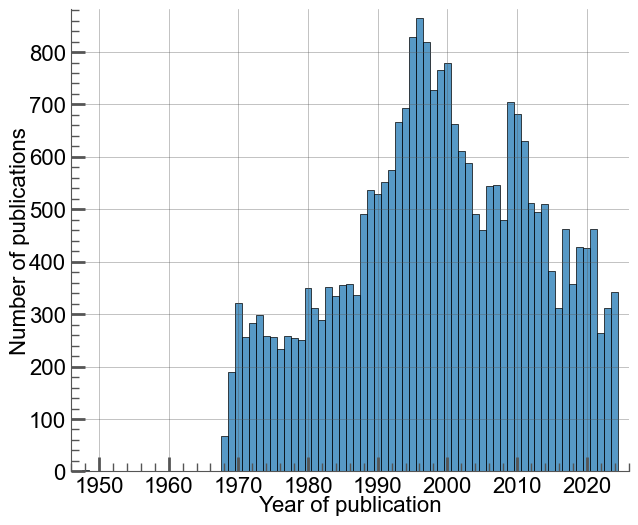

<Figure size 640x480 with 0 Axes>

In [4]:
years = works["year"].to_numpy()

with aq.load_theme("scientific"):
    sns.set_palette("viridis")
    plt.figure(figsize=(7.2, 6))
    sns.histplot(x=years, discrete=True, color="tab:blue")  
    plt.xlabel("Year of publication", fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("Number of publications", fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

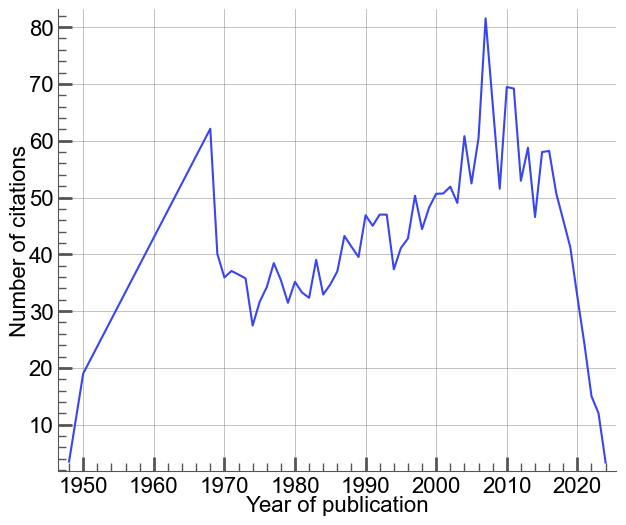

Mean citations count: 42.38948057642805
Median citations count: 41.33197556008147


In [5]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_year_mean, x = "year", y = "cited_by_count", color = "#3944f3")
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of citations", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

mean_value = group_year_mean["cited_by_count"].mean()
median_value = group_year_mean["cited_by_count"].median()
print(f"Mean citations count: {mean_value}")
print(f"Median citations count: {median_value}")

<Figure size 640x480 with 0 Axes>

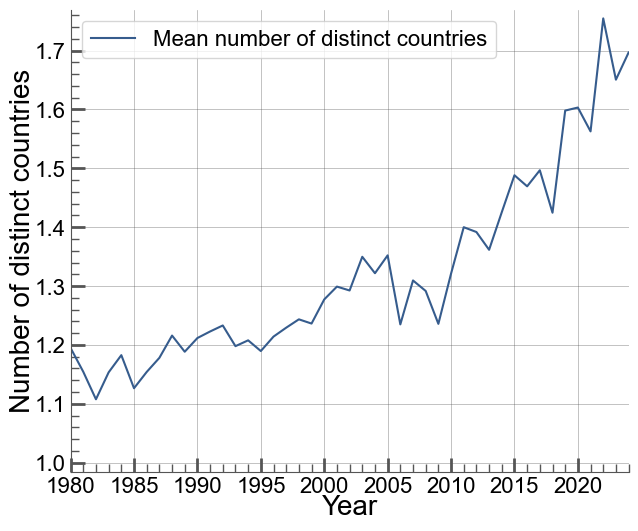

In [6]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_year_mean, x = "year", y = "countries_distinct_count", color = sns.color_palette("viridis")[1], label='Mean number of distinct countries')
    plt.xlim(1980, 2024)
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Number of distinct countries", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

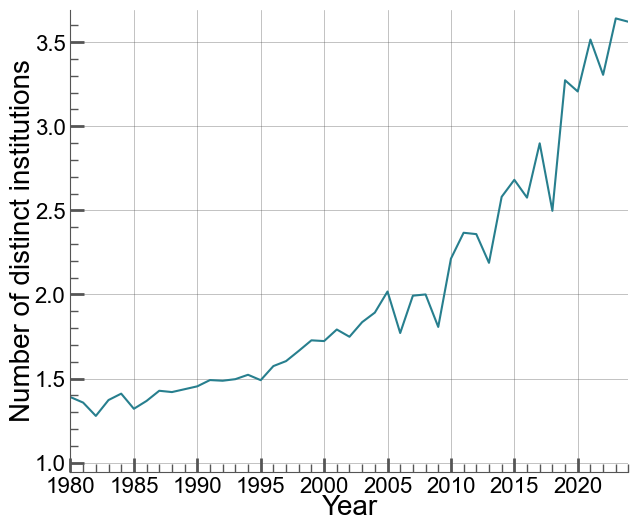

In [7]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_year_mean, x = "year", y = "institutions_distinct_count", color = sns.color_palette("viridis")[2])
    plt.xlim(1980, 2024)
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Number of distinct institutions", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [8]:

slope, intercept = np.polyfit(group_year_mean["year"], group_year_mean["referenced_works_count"], 1)
r_pearson, p_pearson = st.pearsonr(group_year_mean["year"], group_year_mean["referenced_works_count"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(group_year_mean["year"], group_year_mean["referenced_works_count"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.943, p-value = 0.000
Spearman: rho = 0.976, p-value = 0.000


<Figure size 640x480 with 0 Axes>

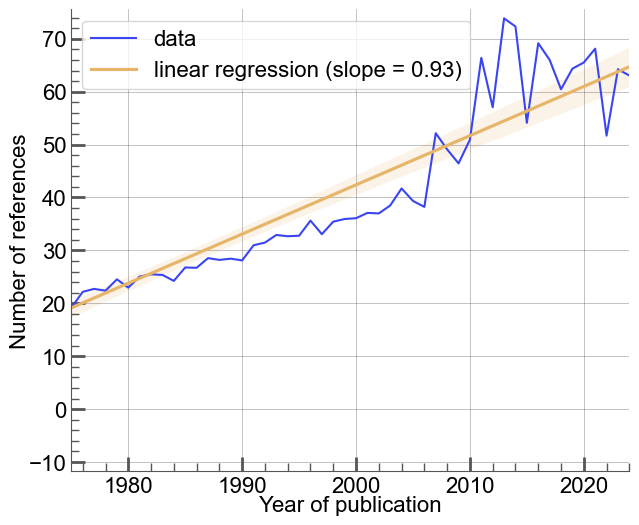

In [9]:
color_gold = "#e6b567"

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_year_mean, x = "year", y = "referenced_works_count", color = "#3944f3", label = "data")
    sns.regplot(data = group_year_mean, x = "year", y = "referenced_works_count", color = color_gold, scatter=False, label=f"linear regression (slope = {slope:.2f})")
    plt.xlim(1975, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of references", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

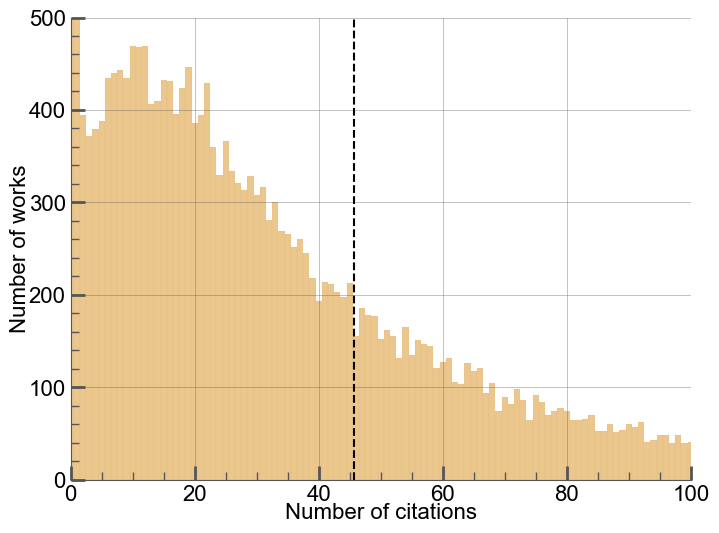

In [10]:

cited_counts = works["cited_by_count"].to_numpy()
mean_cited = cited_counts.mean()


with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    sns.histplot(x=cited_counts, bins=range(0, 400), discrete=True, color=color_gold)  
    plt.xlim(0, 100)
    plt.ylim(0, 500)
    plt.axvline(x=mean_cited, color="black", linestyle='dashed')
    plt.xlabel("Number of citations", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

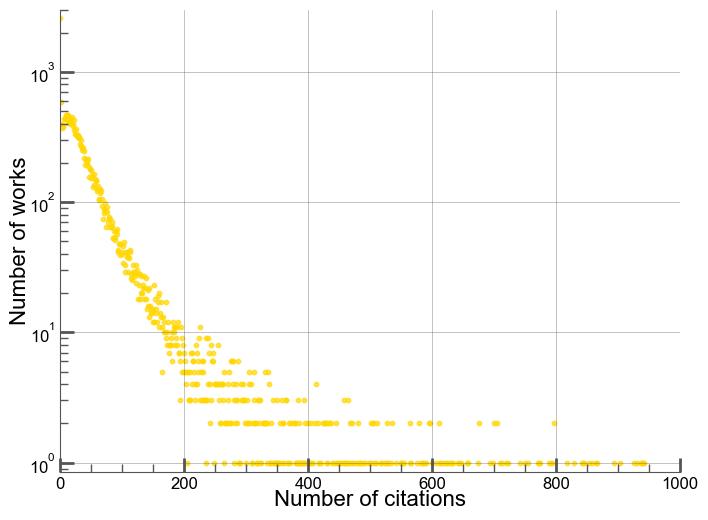

In [11]:

counts = (
    works
    .group_by("cited_by_count")
    .agg(pl.len())
    .sort("cited_by_count")
)

x = counts["cited_by_count"].to_numpy()
y = counts["len"].to_numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10, color="gold", alpha=0.7)
plt.yscale("log")
plt.xlim(0, 1000)
plt.xlabel("Number of citations", fontsize=16)
plt.ylabel("Number of works", fontsize=16)
plt.show()

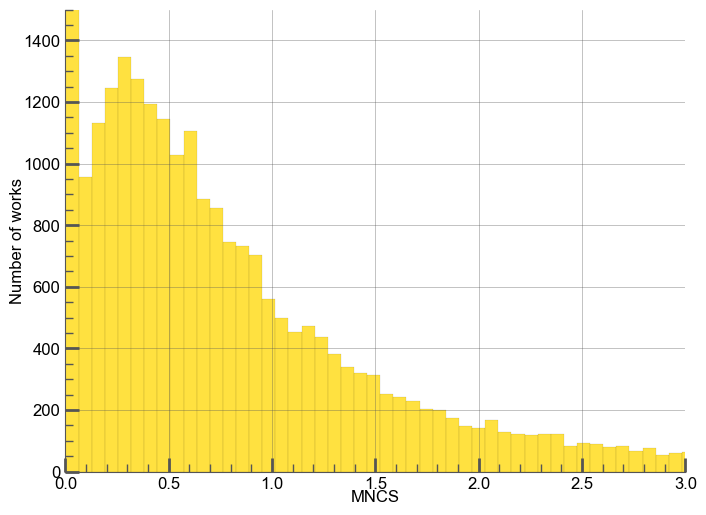

In [12]:
mncs_values = works["mncs"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    sns.histplot(x=mncs_values, discrete=False, color="gold") 
    plt.xlim(0, 3)
    plt.ylim(0, 1500)
    plt.xlabel("MNCS")
    plt.ylabel("Number of works")
    plt.show()

<Figure size 640x480 with 0 Axes>

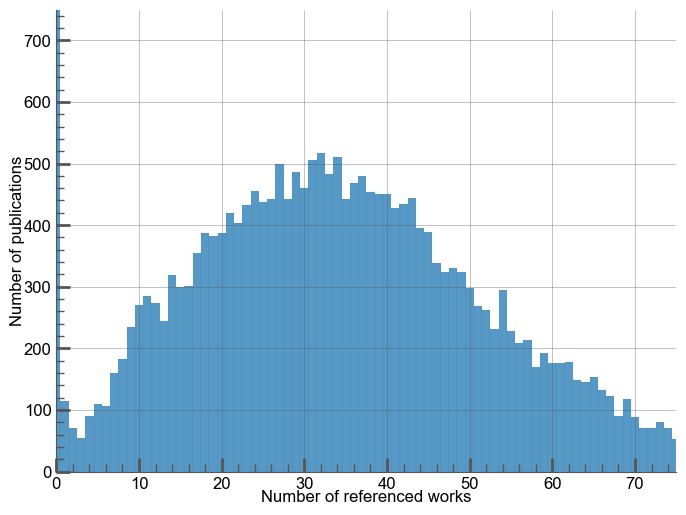

In [13]:

referenced_counts = works["referenced_works_count"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    sns.histplot(x=referenced_counts, color="tab:blue", discrete=True)  # ou color_ensta si défini
    plt.xlim(0, 75)
    plt.ylim(0, 750)
    plt.xlabel("Number of referenced works")
    plt.ylabel("Number of publications")
    plt.show()

<Figure size 640x480 with 0 Axes>

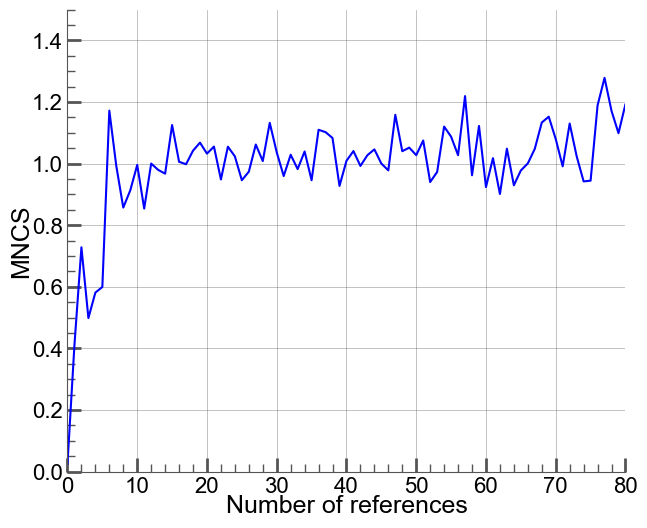

In [14]:
x = group_references_mean["referenced_works_count"].to_numpy()  
y = group_references_mean["mncs"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(x=x, y=y, color="blue")
    plt.xlim(0, 80)
    plt.ylim(0, 1.5)
    plt.xlabel("Number of references", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

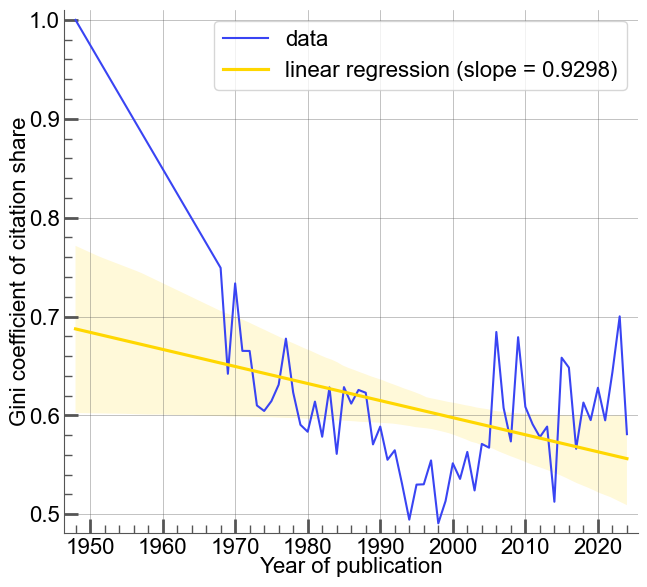

In [15]:

x = list(range(year_begin, year_end + 1))
y = ginis  

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.4, 6.8))
    
    # Ligne des données
    sns.lineplot(x=x, y=y, color="#3944f3", label="data")
    
    # Régression linéaire
    sns.regplot(x=x, y=y, color="gold", scatter=False, 
                label=f"linear regression (slope = {slope:.4f})")
    
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Gini coefficient of citation share", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.show()


In [16]:
unique_counts = works.select("authors_count").unique().sort("authors_count").to_series().to_list() 
results = [] 
for ac in unique_counts: 
    chunk = works.filter(pl.col("authors_count") == ac) 
    mean_cited_by = chunk["cited_by_count"].mean() 
    mean_mncs = chunk["mncs"].mean() 
    results.append([ac, ac, mean_cited_by, mean_mncs]) 
    
    
group_Nauthors_mean = pl.DataFrame( results, schema=["by", "authors_count", "cited_by_count", "mncs"] ) 
results_low = [] 
for ac in unique_counts: 
    chunk = works.filter((pl.col("authors_count") == ac) & (pl.col("mncs") < 0.1)) 
    if len(chunk) == 0: 
        continue 
    mean_cited_by = chunk["cited_by_count"].mean() 
    mean_mncs = chunk["mncs"].mean() 
    results_low.append([ac, ac, mean_cited_by, mean_mncs]) 
    
group_Nauthors_mean_low_citations = pl.DataFrame( 
results_low, schema=["by", "authors_count", "cited_by_count", "mncs"] ) 
group_Nauthors_mean

C:\Users\noahr\AppData\Local\Temp\ipykernel_452\2901082391.py:10: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  group_Nauthors_mean = pl.DataFrame( results, schema=["by", "authors_count", "cited_by_count", "mncs"] )
C:\Users\noahr\AppData\Local\Temp\ipykernel_452\2901082391.py:20: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  group_Nauthors_mean_low_citations = pl.DataFrame(


shape: (41, 4)
┌─────┬───────────────┬────────────────┬───────────┐
│ by  ┆ authors_count ┆ cited_by_count ┆ mncs      │
│ --- ┆ ---           ┆ ---            ┆ ---       │
│ i64 ┆ i64           ┆ f64            ┆ f64       │
╞═════╪═══════════════╪════════════════╪═══════════╡
│ 0   ┆ 0             ┆ 0.755864       ┆ 0.015755  │
│ 1   ┆ 1             ┆ 50.523105      ┆ 1.075685  │
│ 2   ┆ 2             ┆ 45.155105      ┆ 1.046216  │
│ 3   ┆ 3             ┆ 47.583956      ┆ 1.053192  │
│ 4   ┆ 4             ┆ 51.272675      ┆ 1.105549  │
│ …   ┆ …             ┆ …              ┆ …         │
│ 50  ┆ 50            ┆ 157.0          ┆ 13.100829 │
│ 53  ┆ 53            ┆ 256.0          ┆ 10.58173  │
│ 58  ┆ 58            ┆ 238.0          ┆ 9.837702  │
│ 73  ┆ 73            ┆ 141.0          ┆ 11.765713 │
│ 100 ┆ 100           ┆ 245.333333     ┆ 10.275338 │
└─────┴───────────────┴────────────────┴───────────┘

In [17]:

authors = (
    works
    .select(["title", "year", "cited_by_count", "mncs", *cols_authors])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=cols_authors,
        index=["title", "year", "index_work", "cited_by_count", "mncs"],
        variable_name="author_pos",
        value_name="author_name"
    )
    .filter(pl.col("author_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8)) 
)

authors.drop("title")



shape: (112_131, 7)
┌──────┬────────────┬────────────────┬───────────┬────────────┬────────────────────────────┬───────┐
│ year ┆ index_work ┆ cited_by_count ┆ mncs      ┆ author_pos ┆ author_name                ┆ count │
│ ---  ┆ ---        ┆ ---            ┆ ---       ┆ ---        ┆ ---                        ┆ ---   │
│ i64  ┆ u32        ┆ i64            ┆ f64       ┆ str        ┆ str                        ┆ i8    │
╞══════╪════════════╪════════════════╪═══════════╪════════════╪════════════════════════════╪═══════╡
│ 1948 ┆ 0          ┆ 7              ┆ 2.0       ┆ author_1   ┆ https://openalex.org/A5114 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 2497…                      ┆       │
│ 1948 ┆ 1          ┆ 0              ┆ 0.0       ┆ author_1   ┆ https://openalex.org/A5108 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 5631…                      ┆       │
│ 1950 ┆ 2          ┆ 19             ┆ 1.0       ┆ author_1   ┆ https://openalex.org/A5086 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 3853…                      ┆       │
│ 1968 ┆ 3          ┆ 1402           ┆ 22.574862 ┆ author_1   ┆ https://openalex.org/A5110 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 2298…                      ┆       │
│ 1968 ┆ 4          ┆ 564            ┆ 9.081471  ┆ author_1   ┆ https://openalex.org/A5102 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 7517…                      ┆       │
│ …    ┆ …          ┆ …              ┆ …         ┆ …          ┆ …                          ┆ …     │
│ 2021 ┆ 24733      ┆ 469            ┆ 19.386061 ┆ author_100 ┆ https://openalex.org/A5060 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 7332…                      ┆       │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ author_100 ┆ https://openalex.org/A5110 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 9292…                      ┆       │
│ 2022 ┆ 25441      ┆ 0              ┆ 0.0       ┆ author_100 ┆ https://openalex.org/A5094 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 4776…                      ┆       │
│ 2022 ┆ 25454      ┆ 0              ┆ 0.0       ┆ author_100 ┆ https://openalex.org/A5094 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 3737…                      ┆       │
│ 2023 ┆ 25461      ┆ 303            ┆ 25.283766 ┆ author_100 ┆ https://openalex.org/A5048 ┆ 1     │
│      ┆            ┆                ┆           ┆            ┆ 6557…                      ┆       │
└──────┴────────────┴────────────────┴───────────┴────────────┴────────────────────────────┴───────┘

In [18]:
top_authors = (
    authors
    .group_by(by = "author_name")
    .sum()
    .sort(by = "cited_by_count", descending=True)
    .drop(["index_work", "author_name"])
)

active_authors = (
    authors
    .group_by(by = "author_name")
    .sum()
    .sort(by = "count", descending=True)
    .drop(["index_work", "author_name"])
)


top_authors

shape: (63_062, 7)
┌──────────────────────────────┬───────┬────────┬────────────────┬────────────┬────────────┬───────┐
│ by                           ┆ title ┆ year   ┆ cited_by_count ┆ mncs       ┆ author_pos ┆ count │
│ ---                          ┆ ---   ┆ ---    ┆ ---            ┆ ---        ┆ ---        ┆ ---   │
│ str                          ┆ str   ┆ i64    ┆ i64            ┆ f64        ┆ str        ┆ i64   │
╞══════════════════════════════╪═══════╪════════╪════════════════╪════════════╪════════════╪═══════╡
│ https://openalex.org/A509041 ┆ null  ┆ 482324 ┆ 21840          ┆ 593.124999 ┆ null       ┆ 240   │
│ 97…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A500535 ┆ null  ┆ 141409 ┆ 14765          ┆ 333.983792 ┆ null       ┆ 71    │
│ 78…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A506830 ┆ null  ┆ 154809 ┆ 12234          ┆ 366.481811 ┆ null       ┆ 77    │
│ 97…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A502895 ┆ null  ┆ 98876  ┆ 12065          ┆ 356.596461 ┆ null       ┆ 49    │
│ 49…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A505376 ┆ null  ┆ 134920 ┆ 11872          ┆ 363.014945 ┆ null       ┆ 67    │
│ 50…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ …                            ┆ …     ┆ …      ┆ …              ┆ …          ┆ …          ┆ …     │
│ https://openalex.org/A501039 ┆ null  ┆ 2024   ┆ 0              ┆ 0.0        ┆ null       ┆ 1     │
│ 07…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A503443 ┆ null  ┆ 2024   ┆ 0              ┆ 0.0        ┆ null       ┆ 1     │
│ 98…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A500267 ┆ null  ┆ 2006   ┆ 0              ┆ 0.0        ┆ null       ┆ 1     │
│ 00…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A505878 ┆ null  ┆ 2003   ┆ 0              ┆ 0.0        ┆ null       ┆ 1     │
│ 57…                          ┆       ┆        ┆                ┆            ┆            ┆       │
│ https://openalex.org/A507485 ┆ null  ┆ 3940   ┆ 0              ┆ 0.0        ┆ null       ┆ 2     │
│ 10…                          ┆       ┆        ┆                ┆            ┆            ┆       │
└──────────────────────────────┴───────┴────────┴────────────────┴────────────┴────────────┴───────┘

In [19]:
import pyalex as alex

top_10_authors = top_authors.head(20)

names = []
institutions = []
countries = []

for aid in top_10_authors["by"].to_list():
    if not isinstance(aid, str):
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    author = alex.Authors()[aid]
    names.append(author.get("display_name"))

    inst_list = author.get("affiliations") or []
    if len(inst_list) > 0:
        inst_id = inst_list[0]["institution"].get("id")
        if isinstance(inst_id, str):
            institutions.append(inst_id)
            try:
                countries.append(alex.Institutions()[inst_id].get("country_code"))
            except Exception:
                countries.append(None)
        else:
            institutions.append(None)
            countries.append(None)
    else:
        institutions.append(None)
        countries.append(None)

top_10_authors = top_10_authors.with_columns([
    pl.Series("name", names),
    pl.Series("institution", institutions),
    pl.Series("country", countries)
])

top_10_authors


shape: (20, 10)
┌──────────────┬───────┬────────┬──────────────┬───┬───────┬──────────────┬──────────────┬─────────┐
│ by           ┆ title ┆ year   ┆ cited_by_cou ┆ … ┆ count ┆ name         ┆ institution  ┆ country │
│ ---          ┆ ---   ┆ ---    ┆ nt           ┆   ┆ ---   ┆ ---          ┆ ---          ┆ ---     │
│ str          ┆ str   ┆ i64    ┆ ---          ┆   ┆ i64   ┆ str          ┆ str          ┆ str     │
│              ┆       ┆        ┆ i64          ┆   ┆       ┆              ┆              ┆         │
╞══════════════╪═══════╪════════╪══════════════╪═══╪═══════╪══════════════╪══════════════╪═════════╡
│ https://open ┆ null  ┆ 482324 ┆ 21840        ┆ … ┆ 240   ┆ S P H        ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Alexander    ┆ alex.org/I14 ┆         │
│ 904197…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 226353…      ┆         │
│ https://open ┆ null  ┆ 141409 ┆ 14765        ┆ … ┆ 71    ┆ Salvador     ┆ https://open ┆ ES      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Moncada      ┆ alex.org/I63 ┆         │
│ 053578…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 634437       ┆         │
│ https://open ┆ null  ┆ 154809 ┆ 12234        ┆ … ┆ 77    ┆ John A.      ┆ https://open ┆ FR      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Peters       ┆ alex.org/I12 ┆         │
│ 683097…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 946715…      ┆         │
│ https://open ┆ null  ┆ 98876  ┆ 12065        ┆ … ┆ 49    ┆ Elena        ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Faccenda     ┆ alex.org/I98 ┆         │
│ 289549…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 677209       ┆         │
│ https://open ┆ null  ┆ 134920 ┆ 11872        ┆ … ┆ 67    ┆ Eamonn Kelly ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆              ┆ alex.org/I36 ┆         │
│ 537650…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 234482       ┆         │
│ …            ┆ …     ┆ …      ┆ …            ┆ … ┆ …     ┆ …            ┆ …            ┆ …       │
│ https://open ┆ null  ┆ 176910 ┆ 7640         ┆ … ┆ 89    ┆ John R. Vane ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆              ┆ alex.org/I13 ┆         │
│ 593829…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 071953…      ┆         │
│ https://open ┆ null  ┆ 122313 ┆ 7615         ┆ … ┆ 61    ┆ Anthony P.   ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Davenport    ┆ alex.org/I24 ┆         │
│ 606893…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 1749         ┆         │
│ https://open ┆ null  ┆ 203325 ┆ 7046         ┆ … ┆ 102   ┆ J.C. McGrath ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆              ┆ alex.org/I78 ┆         │
│ 593191…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 82870        ┆         │
│ https://open ┆ null  ┆ 165602 ┆ 6906         ┆ … ┆ 83    ┆ Peter J.     ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Barnes       ┆ alex.org/I47 ┆         │
│ 302580…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 508984       ┆         │
│ https://open ┆ null  ┆ 33839  ┆ 6845         ┆ … ┆ 17    ┆ Richard      ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Palmer       ┆ alex.org/I18 ┆         │
│ 561992…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 393575…      ┆         │
└──────────────┴───────┴────────┴──────────────┴───┴───────┴──────────────┴──────────────┴─────────┘

In [20]:
authors = authors.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("author_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("author_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("author_name") - pl.col("mncs")).alias("cumulative_mncs")
])

authors = authors.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_authors")
)
test = authors.filter(pl.col("author_name") == "https://openalex.org/A5080551159")
test

shape: (0, 12)
┌───────┬──────┬────────────┬─────────────┬───┬─────────────┬────────────┬────────────┬────────────┐
│ title ┆ year ┆ index_work ┆ cited_by_co ┆ … ┆ cumulative_ ┆ cumulative ┆ cumulative ┆ mean_past_ │
│ ---   ┆ ---  ┆ ---        ┆ unt         ┆   ┆ count       ┆ _citations ┆ _mncs      ┆ mncs_autho │
│ str   ┆ i64  ┆ u32        ┆ ---         ┆   ┆ ---         ┆ ---        ┆ ---        ┆ rs         │
│       ┆      ┆            ┆ i64         ┆   ┆ i64         ┆ i64        ┆ f64        ┆ ---        │
│       ┆      ┆            ┆             ┆   ┆             ┆            ┆            ┆ f64        │
╞═══════╪══════╪════════════╪═════════════╪═══╪═════════════╪════════════╪════════════╪════════════╡
└───────┴──────┴────────────┴─────────────┴───┴─────────────┴────────────┴────────────┴────────────┘

<Figure size 640x480 with 0 Axes>

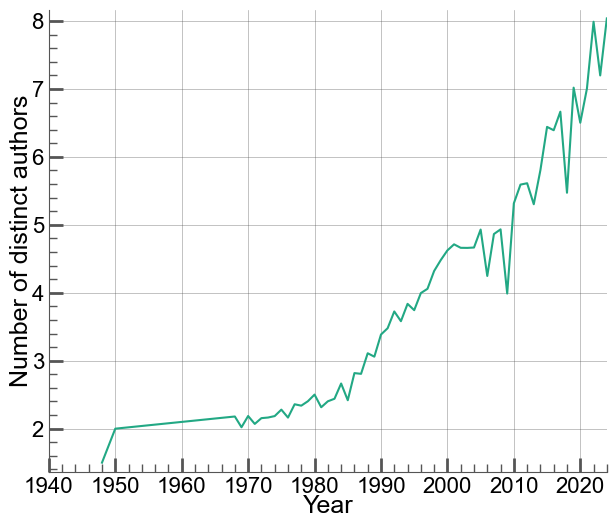

Mean authors count: 4.030371824318393
Median authors count: 3.836940836940837


In [21]:
years = group_year_mean["year"].to_list()
authors_counts = group_year_mean["authors_count"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    plt.plot(years, authors_counts, color=plt.cm.viridis(0.6))  
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("Number of distinct authors", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(1940, 2024)
    plt.show()
    
mean_value = group_year_mean.select(pl.col("authors_count").mean())[0, 0]
median_value = group_year_mean.select(pl.col("authors_count").median())[0, 0]

print(f"Mean authors count: {mean_value}")
print(f"Median authors count: {median_value}")

In [22]:
r_pearson, p_pearson = st.pearsonr(works["authors_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["authors_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.138, p-value = 0.000
Spearman: rho = 0.294, p-value = 0.000


<Figure size 640x480 with 0 Axes>

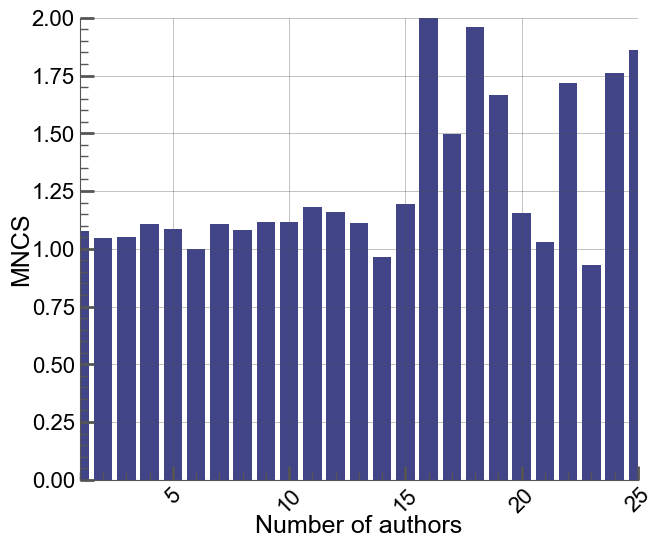

In [23]:
authors_count = group_Nauthors_mean["authors_count"].to_list()
mncs = group_Nauthors_mean["mncs"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    plt.bar(authors_count, mncs, color=plt.cm.viridis(0.2))  # couleur similaire à sns.color_palette("viridis")[1]
    plt.xlim(1, 25)
    plt.ylim(0, 2)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of authors", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

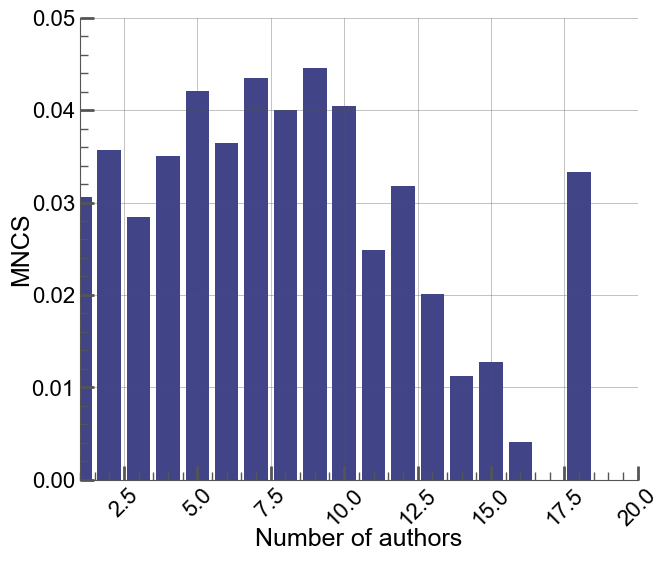

In [24]:
authors_count = group_Nauthors_mean_low_citations["authors_count"].to_list()
mncs = group_Nauthors_mean_low_citations["mncs"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    plt.bar(authors_count, mncs, color=plt.cm.viridis(0.2))  
    plt.xlim(1, 20)
    plt.ylim(0, 0.05)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of authors", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

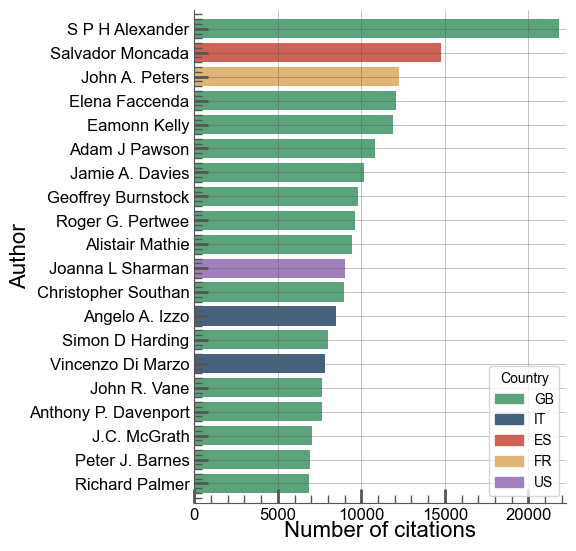

In [25]:
palette = ["#5aa37b", "#45637d", "#cc6355", "#e0b474", "#a17fbd", "#f28c34", "#6fb1fc", "#f5a6e1"]

names = top_10_authors["name"].to_list()
citations = top_10_authors["cited_by_count"].to_list()
countries = top_10_authors["country"].to_list()

unique_countries = list(set(countries))
country_colors = {country: palette[i % len(palette)] for i, country in enumerate(unique_countries)}
colors = [country_colors[c] for c in countries]

names = names[::-1]
citations = citations[::-1]
colors = colors[::-1]

with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8, 6.4))
    plt.barh(names, citations, color=colors)
    plt.xlabel("Number of citations", fontsize=16)
    plt.ylabel("Author", fontsize=16)

    handles = [plt.Rectangle((0,0),1,1, color=country_colors[c]) for c in unique_countries]
    plt.legend(handles, unique_countries, title="Country")

    plt.show()

<Figure size 640x480 with 0 Axes>

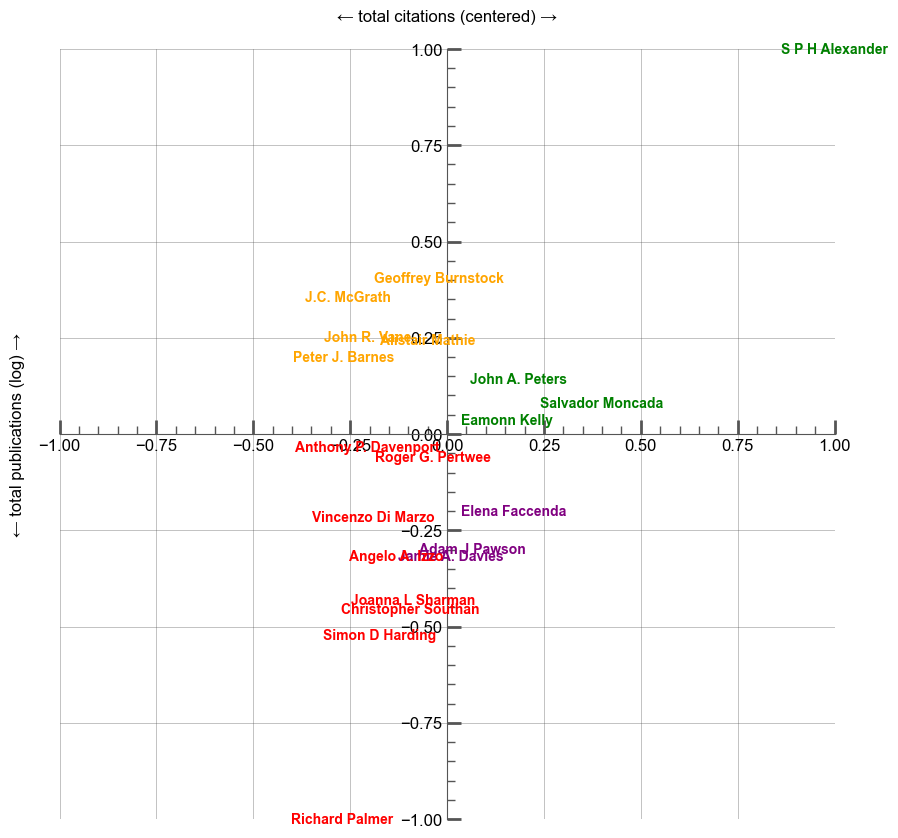

In [26]:

top_10_authors = top_10_authors.with_columns([
    pl.col("count").log().alias("publications_log"),  # log des publications
])

mean_cit = top_10_authors["cited_by_count"].mean()
top_10_authors = top_10_authors.with_columns(
    (pl.col("cited_by_count") - mean_cit).alias("citations_centered")  # citations centrées
)


pub_log = top_10_authors["publications_log"].to_numpy()
y_min = np.min(pub_log)
y_max = np.max(pub_log)

citations = top_10_authors["cited_by_count"].to_numpy()
cit_mean = np.mean(citations)
cit_max_abs = np.max(np.abs(citations - cit_mean))

top_10_authors = top_10_authors.with_columns([
    ((pl.col("publications_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
    ((pl.col("cited_by_count") - cit_mean) / cit_max_abs).alias("x_viz")
])
# --- Plot ---
plt.figure(figsize=(10, 10))
for name, x, y in zip(
    top_10_authors["name"],
    top_10_authors["x_viz"],
    top_10_authors["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← total citations (centered) →", labelpad=-320)
plt.ylabel("← total publications (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

plt.show()


In [27]:
countries_col = [f"country_{i}" for i in range(1, 120)]

countries = (
    works
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8)) 
)

countries

shape: (110_926, 7)
┌──────┬────────────┬────────────────┬───────────┬─────────────┬──────────────┬───────┐
│ year ┆ index_work ┆ cited_by_count ┆ mncs      ┆ country_pos ┆ country_name ┆ count │
│ ---  ┆ ---        ┆ ---            ┆ ---       ┆ ---         ┆ ---          ┆ ---   │
│ i64  ┆ u32        ┆ i64            ┆ f64       ┆ str         ┆ str          ┆ i8    │
╞══════╪════════════╪════════════════╪═══════════╪═════════════╪══════════════╪═══════╡
│ 1968 ┆ 3          ┆ 1402           ┆ 22.574862 ┆ country_1   ┆ US           ┆ 1     │
│ 1968 ┆ 5          ┆ 276            ┆ 4.444124  ┆ country_1   ┆ SE           ┆ 1     │
│ 1968 ┆ 6          ┆ 134            ┆ 2.157654  ┆ country_1   ┆ CH           ┆ 1     │
│ 1968 ┆ 7          ┆ 131            ┆ 2.109349  ┆ country_1   ┆ AU           ┆ 1     │
│ 1968 ┆ 8          ┆ 130            ┆ 2.093247  ┆ country_1   ┆ GB           ┆ 1     │
│ …    ┆ …          ┆ …              ┆ …         ┆ …           ┆ …            ┆ …     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_117 ┆ NO           ┆ 1     │
│ 2022 ┆ 25441      ┆ 0              ┆ 0.0       ┆ country_117 ┆ JP           ┆ 1     │
│ 2022 ┆ 25454      ┆ 0              ┆ 0.0       ┆ country_117 ┆ JP           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_118 ┆ NO           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_119 ┆ NL           ┆ 1     │
└──────┴────────────┴────────────────┴───────────┴─────────────┴──────────────┴───────┘

In [28]:
group_countriesyears = (
    countries
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)
group_countries = (
    countries
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(
        count=pl.col("count").sum(),
        mean_mncs=pl.col("mncs").mean(),
        mean_cited_by_count=pl.col("cited_by_count").mean(),
        mean_age=pl.col("age").mean()
    )
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

In [29]:
group_countriesyears = (
    group_countriesyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("country_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("country_name"),
        cum_count=pl.col("count").cum_sum().over("country_name")
    ) 
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
)
group_Ncountries_mean = (
    works.select(["cited_by_count", "countries_distinct_count", "mncs"])
    .group_by("countries_distinct_count")
    .mean()
) 
top_countries = (
    group_countries
    .sort("count", descending=True)
    .head(10)
    .select("country_name")
    .to_series()
    .to_list()
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_452\3916111987.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = age_countries, x = "country_name", y = "mean_age", palette = "viridis_r")


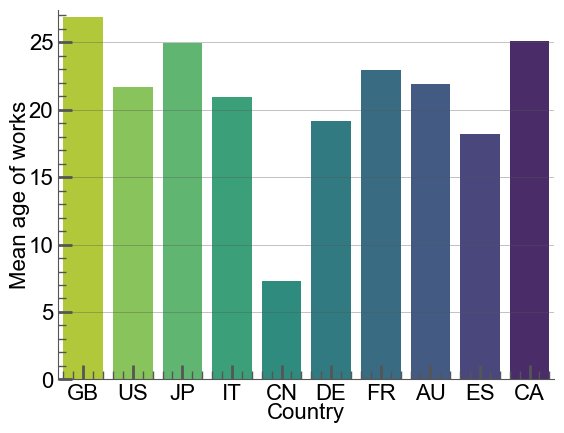

In [30]:
age_countries = (
    group_countries
    .sort("count", descending=True)
    .head(10)
)
with aq.load_theme("scientific"):
    sns.barplot(data = age_countries, x = "country_name", y = "mean_age", palette = "viridis_r")
    plt.ylabel("Mean age of works", fontsize=16)
    plt.xlabel("Country", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

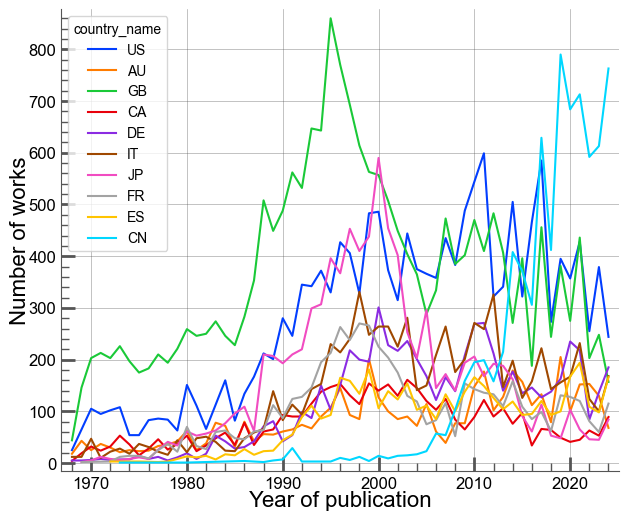

In [31]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_countriesyears.filter(pl.col("country_name").is_in(top_countries)), x = "year", y = "count", hue = "country_name", palette = "bright")
    #plt.xlim(1980, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

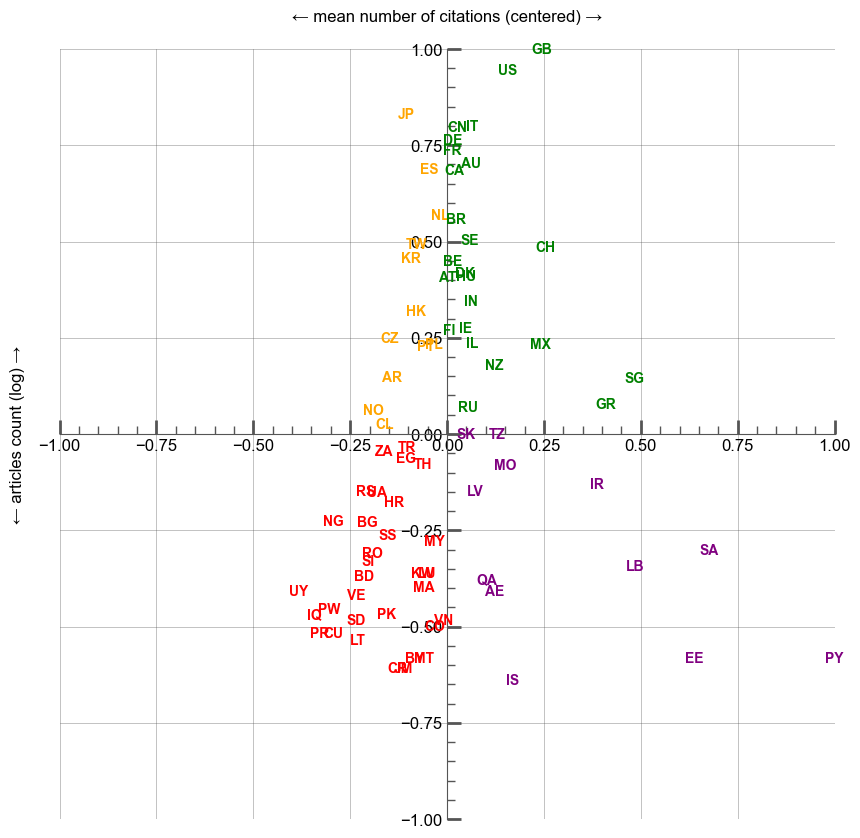

In [32]:
group_countries_filtered = group_countries.filter(pl.col("count") > 5)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)

mean_mncs_mean = group_countries_filtered["mean_mncs"].mean()
group_countries_filtered = group_countries_filtered.with_columns(
    (pl.col("mean_mncs") - mean_mncs_mean).alias("mean_mncs_centered")
)
count_log_max = group_countries_filtered["count_log"].max()
mean_mncs_centered_max = group_countries_filtered["mean_mncs_centered"].abs().max() 

group_countries_filtered = group_countries_filtered.with_columns([
    (-1 + 2 * pl.col("count_log") / count_log_max).alias("count_viz"),
    (pl.col("mean_mncs_centered") / mean_mncs_centered_max).alias("mean_mncs_viz")
])

country_names = group_countries_filtered["country_name"].to_list()
count_viz = group_countries_filtered["count_viz"].to_list()
mean_mncs_viz = group_countries_filtered["mean_mncs_viz"].to_list()

plt.figure(figsize=(10, 10))
for name, x, y in zip(country_names, mean_mncs_viz, count_viz):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:  
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← mean number of citations (centered) →", labelpad=-320)
plt.ylabel("← articles count (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')  
ax.spines['bottom'].set_position('zero') 

plt.show()

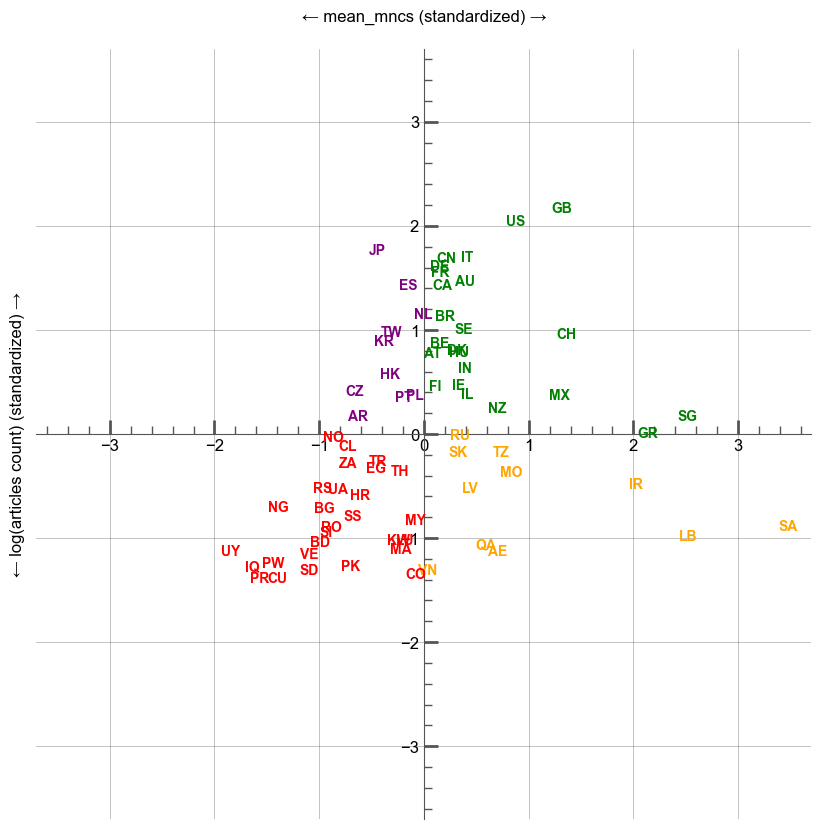

In [33]:
group_countries_filtered = group_countries.filter(pl.col("count") > 10)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)


mean_mncs_mean = group_countries_filtered["mean_mncs"].mean()
mean_mncs_std = group_countries_filtered["mean_mncs"].std()
count_log_mean = group_countries_filtered["count_log"].mean()
count_log_std = group_countries_filtered["count_log"].std()

group_countries_filtered = group_countries_filtered.with_columns([
    ((pl.col("mean_mncs") - mean_mncs_mean)/mean_mncs_std).alias("mean_mncs_viz"),
    ((pl.col("count_log") - count_log_mean)/count_log_std).alias("count_viz")
])


country_names = group_countries_filtered["country_name"].to_list()
mean_mncs_viz = group_countries_filtered["mean_mncs_viz"].to_list()
count_viz = group_countries_filtered["count_viz"].to_list()


plt.figure(figsize=(10, 10))
for name, x, y in zip(country_names, mean_mncs_viz, count_viz):
    if x >= 0 and y >= 0:
        color = "green"
    elif x < 0 and y >= 0:
        color = "purple"
    elif x < 0 and y < 0:
        color = "red"
    else:  
        color = "orange"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← mean_mncs (standardized) →", labelpad=-320)
plt.ylabel("← log(articles count) (standardized) →", labelpad=270)
plt.xlim(-3.7, 3.7)
plt.ylim(-3.7, 3.7)

ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

plt.show()

In [34]:
r_pearson, p_pearson = st.pearsonr(works["countries_distinct_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["countries_distinct_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.138, p-value = 0.000
Spearman: rho = 0.141, p-value = 0.000


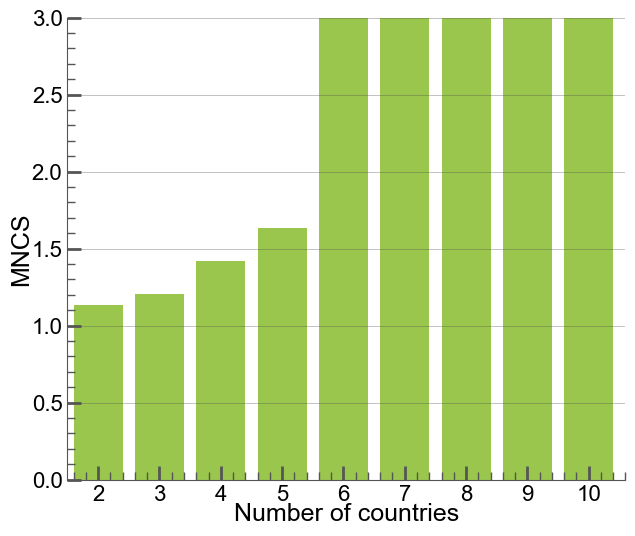

In [35]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.barplot(data = group_Ncountries_mean, x = "countries_distinct_count", y = "mncs", color = sns.color_palette("viridis")[5])
    plt.xlim(0.5, 9.6)
    plt.ylim(0,3)
    # plt.xticks(rotation = 45)
    plt.xlabel("Number of countries", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [36]:
institutions_col = [f"institution_{i}" for i in range(1, 126)]

institutions = (
    works
    .select(["year", "cited_by_count", "mncs", *institutions_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=institutions_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="institution_pos",
        value_name="institution_name"
    )
    .filter(pl.col("institution_name").is_not_null())
    .with_columns([
        pl.lit(1, dtype=pl.Int8).alias("count"),
        pl.col("institution_name")
          .str.split("',", inclusive=False)
          .list.get(0)
          .str.slice(2)
          .alias("institution_simple")
    ])
)


In [37]:
group_institutionsyears = (
    institutions
    .drop("institution_pos")
    .group_by(["institution_simple", "year", "institution_name"]).sum()
    .sort("year")
)
group_institutions_sum = (
    institutions
    .select(["institution_simple", "count", "cited_by_count", "mncs", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("cited_by_count", descending=True)

In [38]:
top_institutions = (
    group_institutions_sum
    .sort("count", descending=True)
    .head(5)
    .select("institution_simple")
    .to_series().to_list()
)
group_institutionsyears = (
    group_institutionsyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("institution_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("institution_name"),
        cum_count=pl.col("count").cum_sum().over("institution_name")
    )
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
    .sort("count", descending=True)
)

In [39]:
group_Ninstitutions_mean = (
    works
    .select(["cited_by_count", "institutions_distinct_count", "mncs"])
    .group_by(by = "institutions_distinct_count")
    .mean()
)
group_Ninstitutionscountries_mean = (
    works
    .select(["cited_by_count", "institutions_distinct_count", "mncs"])
    .group_by(by = "institutions_distinct_count")
    .mean()
)


In [40]:
institutions = institutions.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("institution_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("institution_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("institution_name") - pl.col("mncs")).alias("cumulative_mncs")
])

institutions = institutions.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_institutions")
)

institutions

shape: (129_669, 12)
┌──────┬────────────┬────────────┬───────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ year ┆ index_work ┆ cited_by_c ┆ mncs      ┆ … ┆ cumulative ┆ cumulative ┆ cumulativ ┆ mean_past │
│ ---  ┆ ---        ┆ ount       ┆ ---       ┆   ┆ _count     ┆ _citations ┆ e_mncs    ┆ _mncs_ins │
│ i64  ┆ u32        ┆ ---        ┆ f64       ┆   ┆ ---        ┆ ---        ┆ ---       ┆ titutions │
│      ┆            ┆ i64        ┆           ┆   ┆ i64        ┆ i64        ┆ f64       ┆ ---       │
│      ┆            ┆            ┆           ┆   ┆            ┆            ┆           ┆ f64       │
╞══════╪════════════╪════════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1968 ┆ 3          ┆ 1402       ┆ 22.574862 ┆ … ┆ 0          ┆ 0          ┆ 0.0       ┆ 1.0       │
│ 1968 ┆ 3          ┆ 1402       ┆ 22.574862 ┆ … ┆ 0          ┆ 0          ┆ 0.0       ┆ 1.0       │
│ 1968 ┆ 5          ┆ 276        ┆ 4.444124  ┆ … ┆ 0          ┆ 0          ┆ 0.0       ┆ 1.0       │
│ 1968 ┆ 5          ┆ 276        ┆ 4.444124  ┆ … ┆ 0          ┆ 0          ┆ 0.0       ┆ 1.0       │
│ 1968 ┆ 5          ┆ 276        ┆ 4.444124  ┆ … ┆ 1          ┆ 276        ┆ 4.444124  ┆ 4.444124  │
│ …    ┆ …          ┆ …          ┆ …         ┆ … ┆ …          ┆ …          ┆ …         ┆ …         │
│ 2024 ┆ 26114      ┆ 0          ┆ 0.0       ┆ … ┆ 76         ┆ 2809       ┆ 58.796911 ┆ 0.773644  │
│ 2024 ┆ 26114      ┆ 0          ┆ 0.0       ┆ … ┆ 16         ┆ 614        ┆ 12.402218 ┆ 0.775139  │
│ 2024 ┆ 26114      ┆ 0          ┆ 0.0       ┆ … ┆ 5          ┆ 95         ┆ 2.195109  ┆ 0.439022  │
│ 2024 ┆ 26114      ┆ 0          ┆ 0.0       ┆ … ┆ 77         ┆ 2809       ┆ 58.796911 ┆ 0.763596  │
│ 2024 ┆ 26114      ┆ 0          ┆ 0.0       ┆ … ┆ 17         ┆ 614        ┆ 12.402218 ┆ 0.729542  │
└──────┴────────────┴────────────┴───────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [41]:
institutions_agg = institutions.group_by("index_work").agg([
    pl.col("cumulative_count").mean().alias("mean_past_contributions_institutions"),
    pl.col("mean_past_mncs_institutions").mean().alias("mean_past_mncs_institutions")
])


works = (
    works
    .sort("year")
    .with_row_count("index_work")  
    .join(institutions_agg, on="index_work", how="left")
    .with_columns([
        pl.col("mean_past_mncs_institutions").fill_null(1),
        pl.col("mean_past_contributions_institutions").fill_null(0)
    ])
)

works

C:\Users\noahr\AppData\Local\Temp\ipykernel_452\1945809411.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("index_work")


shape: (26_115, 397)
┌────────────┬─────────────┬──────┬────────────┬───┬────────┬────────────┬────────────┬────────────┐
│ index_work ┆ title       ┆ year ┆ cited_by_c ┆ … ┆ review ┆ meta_analy ┆ mean_past_ ┆ mean_past_ │
│ ---        ┆ ---         ┆ ---  ┆ ount       ┆   ┆ ---    ┆ sis        ┆ contributi ┆ mncs_insti │
│ u32        ┆ str         ┆ i64  ┆ ---        ┆   ┆ bool   ┆ ---        ┆ ons_instit ┆ tutions    │
│            ┆             ┆      ┆ i64        ┆   ┆        ┆ bool       ┆ …          ┆ ---        │
│            ┆             ┆      ┆            ┆   ┆        ┆            ┆ ---        ┆ f64        │
│            ┆             ┆      ┆            ┆   ┆        ┆            ┆ f64        ┆            │
╞════════════╪═════════════╪══════╪════════════╪═══╪════════╪════════════╪════════════╪════════════╡
│ 0          ┆ the chemo-t ┆ 1948 ┆ 7          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ herapeutie  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ aetion o…   ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 1          ┆ the constit ┆ 1948 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ ution of    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ pbotostilb… ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 2          ┆ antryeide a ┆ 1950 ┆ 19         ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ aew trypano ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ cidal d…    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 3          ┆ stimulus‐se ┆ 1968 ┆ 1402       ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ cretion     ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ coupling:   ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ t…          ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 4          ┆ the         ┆ 1968 ┆ 564        ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ biological  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ properties  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ of t…       ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ …          ┆ …           ┆ …    ┆ …          ┆ … ┆ …      ┆ …          ┆ …          ┆ …          │
│ 26110      ┆ issue       ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ information ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 26111      ┆             ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│ 26112      ┆ inhibition  ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 85.857143  ┆ 1.105603   │
│            ┆ of the      ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ upregulated ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ …           ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 26113      ┆ expression  ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ of concern: ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ dose‐de…    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 26114      ┆ agonists of ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 21.882353  ┆ 0.959609   │
│            ┆ the opioid  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ δ‐recep…    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
└────────────┴─────────────┴──────┴─────

<Figure size 640x480 with 0 Axes>

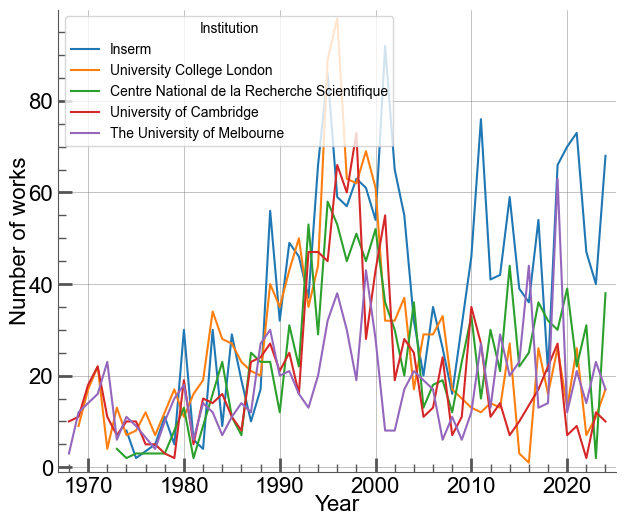

In [42]:
group_filtered = group_institutionsyears.filter( pl.col("institution_simple").is_in(top_institutions) )

group_agg = group_filtered.group_by(["institution_simple", "year"]).agg(
    pl.sum("count").alias("count")
).sort(["institution_simple", "year"])

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
           "#bcbd22", "#17becf"]

unique_institutions = top_institutions
institution_colors = {inst: palette[i % len(palette)] for i, inst in enumerate(unique_institutions)}

plt.figure(figsize=(7.2, 6))

for inst in unique_institutions:
    df_inst = group_agg.filter(pl.col("institution_simple") == inst).sort("year")
    plt.plot(df_inst["year"].to_list(), df_inst["count"].to_list(),
             label=inst, color=institution_colors[inst])

plt.ylabel("Number of works", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Institution")
plt.show()


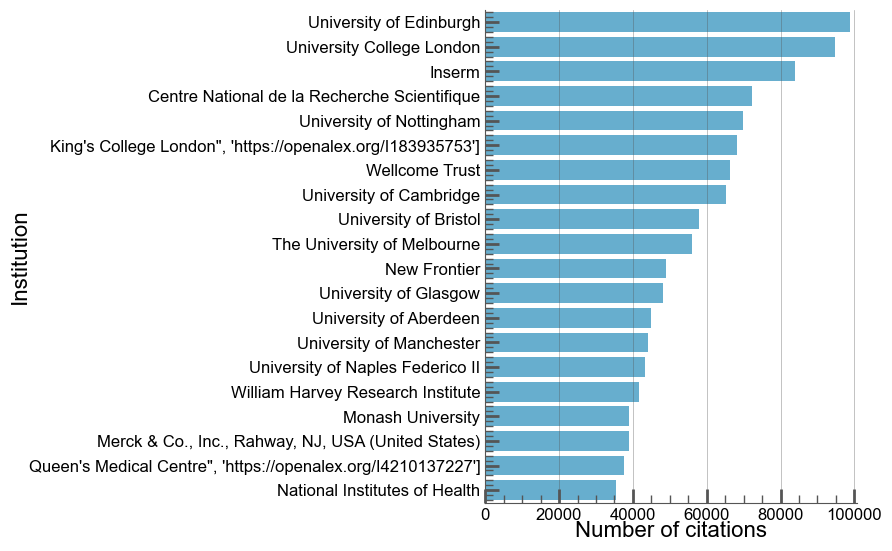

In [43]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum.head(n=20), x = "cited_by_count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.show()

In [44]:
top_10_universities_names = [
    "Harvard University",
    "University College London",
    "University of Washington",
    "University of Michigan",
    "University of California, San Francisco",
    "University of Toronto",
    "Johns Hopkins University",
    "University of California, San Diego",
    "University of North Carolina at Chapel Hill",
    "University of Pennsylvania"
]

top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

In [45]:
test = works[["cited_by_count", "institutions_distinct_count"]].group_by(by = "institutions_distinct_count").len()
test

shape: (30, 2)
┌─────┬───────┐
│ by  ┆ len   │
│ --- ┆ ---   │
│ i64 ┆ u32   │
╞═════╪═══════╡
│ 9   ┆ 52    │
│ 24  ┆ 5     │
│ 1   ┆ 14720 │
│ 12  ┆ 14    │
│ 45  ┆ 1     │
│ …   ┆ …     │
│ 15  ┆ 9     │
│ 2   ┆ 6036  │
│ 25  ┆ 1     │
│ 27  ┆ 1     │
│ 39  ┆ 1     │
└─────┴───────┘

<Figure size 640x480 with 0 Axes>

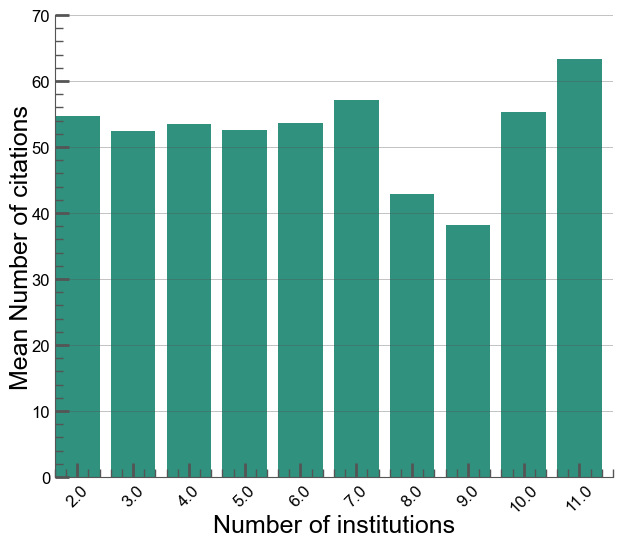

Mean authors count: 1.8828642542600038
Median authors count: 1.0


In [46]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.barplot(data = group_Ninstitutions_mean, x = "institutions_distinct_count", y = "cited_by_count", color = sns.color_palette("viridis")[3])
    plt.xticks(rotation = 45)
    plt.xlabel("Number of institutions", fontsize=18)
    plt.ylabel("Mean Number of citations", fontsize=18)
    plt.xlim(0.6, 10.6)
    plt.ylim(0, 70)
    plt.show()

mean_value = works["institutions_distinct_count"].mean()
median_value = works["institutions_distinct_count"].median()
print(f"Mean authors count: {mean_value}")
print(f"Median authors count: {median_value}")

In [47]:
r_pearson, p_pearson = st.pearsonr(works["countries_distinct_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["countries_distinct_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.138, p-value = 0.000
Spearman: rho = 0.141, p-value = 0.000


<Figure size 640x480 with 0 Axes>

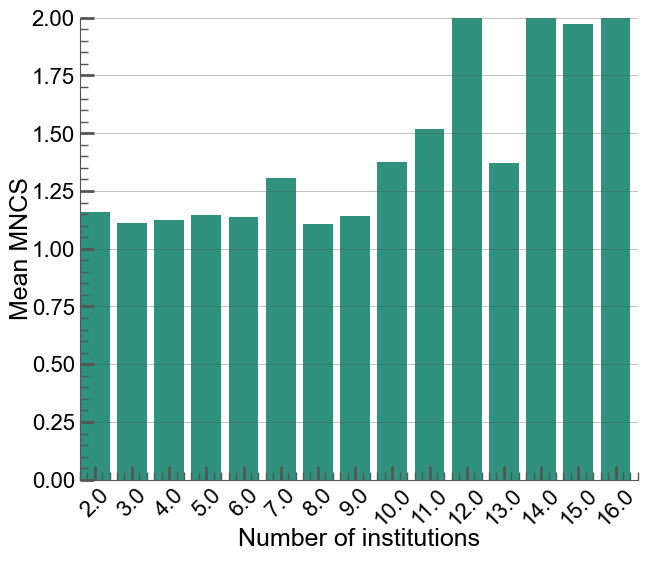

In [48]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.barplot(data = group_Ninstitutions_mean, x = "institutions_distinct_count", y = "mncs", color = sns.color_palette("viridis")[3])
    plt.xticks(rotation = 45)
    plt.xlim(0.6, 15.6)
    plt.ylim(0, 2)
    plt.xlabel("Number of institutions", fontsize=18)
    plt.ylabel("Mean MNCS", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [49]:
bigpharma_names = ["Johnson & Johnson",
                    "Roche", 
                    "Merck", # ! Merck & co != Merck KgaA
                    "Pfizer", 
                    "AbbVie",
                    "AstraZeneca",
                    "Novartis", 
                    "Bristol-Myers Squibb",
                    "Eli Lilly",
                    "Sanofi",
                    "Novo Nordisk",
                    "GlaxoSmithKline",
                    "Amgen",
                    "Takeda",
                    "Boehringer Ingelheim",
                    "Gilead Sciences",
                    "Bayer",
                    "Teva Pharmaceuticals",
                    "CSL",
                    "BMS"
                    ] 

starts_with_expression = pl.col("institution_simple").str.starts_with(bigpharma_names[0])
for name in bigpharma_names[1:]:
    starts_with_expression =  starts_with_expression | pl.col("institution_simple").str.starts_with(name)

bigpharma = (
        institutions
        .filter(
            starts_with_expression
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").str.starts_with("Bristol-Myers Squibb")).then(pl.lit("Bristol-Myers Squibb"))
            .otherwise(pl.col("institution_simple").str.replace_all(r"[(–\-)]", ",").str.split(",").list.get(0).str.strip_chars()) #warning: \ before the - otherwise regex think it's a range of character like a-z=alphabet
            .alias("institution_simple"))
        
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").is_in(["Merck & Co.", "Merck Serono", "Merck Canada Inc.", "Merck Institute for Science Education"])).then(pl.lit("Merck"))
            .when(pl.col("institution_simple").is_in(["Pfizer-University of Granada-Junta de Andalucía Centre for Genomics and Oncological Research"])).then(pl.lit("Pfizer"))
            .when(pl.col("institution_simple").is_in(["Novartis Institutes for BioMedical Research", "Novartis Foundation"])).then(pl.lit("Novartis"))
            .when(pl.col("institution_simple").is_in(["Roche Pharma AG"])).then(pl.lit("Roche"))
            .when(pl.col("institution_simple").is_in(["Novo Nordisk Foundation"])).then(pl.lit("Novo Nordisk"))
            .otherwise(pl.col("institution_simple"))
            .alias("institution_simple"))
        
    )
)

bigpharma

shape: (4_376, 12)
┌──────┬────────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ year ┆ index_work ┆ cited_by_c ┆ mncs     ┆ … ┆ cumulative ┆ cumulative ┆ cumulative ┆ mean_past │
│ ---  ┆ ---        ┆ ount       ┆ ---      ┆   ┆ _count     ┆ _citations ┆ _mncs      ┆ _mncs_ins │
│ i64  ┆ u32        ┆ ---        ┆ f64      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ titutions │
│      ┆            ┆ i64        ┆          ┆   ┆ i64        ┆ i64        ┆ f64        ┆ ---       │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆            ┆ f64       │
╞══════╪════════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 1968 ┆ 6          ┆ 134        ┆ 2.157654 ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ 1968 ┆ 6          ┆ 134        ┆ 2.157654 ┆ … ┆ 1          ┆ 134        ┆ 2.157654   ┆ 2.157654  │
│ 1968 ┆ 27         ┆ 31         ┆ 0.499159 ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ 1968 ┆ 43         ┆ 14         ┆ 0.225427 ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ 1968 ┆ 43         ┆ 14         ┆ 0.225427 ┆ … ┆ 1          ┆ 14         ┆ 0.225427   ┆ 0.225427  │
│ …    ┆ …          ┆ …          ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …         │
│ 2024 ┆ 26020      ┆ 1          ┆ 0.30035  ┆ … ┆ 371        ┆ 31333      ┆ 543.914662 ┆ 1.466077  │
│ 2024 ┆ 26084      ┆ 0          ┆ 0.0      ┆ … ┆ 96         ┆ 6874       ┆ 167.633947 ┆ 1.746187  │
│ 2024 ┆ 26084      ┆ 0          ┆ 0.0      ┆ … ┆ 1          ┆ 141        ┆ 2.399196   ┆ 2.399196  │
│ 2024 ┆ 26084      ┆ 0          ┆ 0.0      ┆ … ┆ 2          ┆ 141        ┆ 2.399196   ┆ 1.199598  │
│ 2024 ┆ 26084      ┆ 0          ┆ 0.0      ┆ … ┆ 97         ┆ 6874       ┆ 167.633947 ┆ 1.728185  │
└──────┴────────────┴────────────┴──────────┴───┴────────────┴────────────┴────────────┴───────────┘

In [50]:
errors = [
    "Rochester General Hospital",
    "Rochester Institute of Technology",
    "Bayero University Kano",
    "Bayerisches Landesamt für Gesundheit und Lebensmittelsicherheit"
]

group_bigpharma = (
    bigpharma
    .drop(["institution_name", "institution_pos"])
    .group_by(by = "institution_simple", maintain_order=True)
    .sum()
    .sort("cited_by_count", descending=True)
    .filter(~(pl.col("by").is_in(errors)))
)

group_bigpharma = group_bigpharma.with_columns(
    kind = pl.lit("Company"),
    institution_simple = pl.col("by")
).drop(["by", "index_work", "year"])

group_bigpharma

shape: (19, 9)
┌────────────┬────────────┬───────┬────────────┬───┬────────────┬────────────┬───────────┬─────────┐
│ cited_by_c ┆ mncs       ┆ count ┆ institutio ┆ … ┆ cumulative ┆ cumulative ┆ mean_past ┆ kind    │
│ ount       ┆ ---        ┆ ---   ┆ n_simple   ┆   ┆ _citations ┆ _mncs      ┆ _mncs_ins ┆ ---     │
│ ---        ┆ f64        ┆ i64   ┆ ---        ┆   ┆ ---        ┆ ---        ┆ titutions ┆ str     │
│ i64        ┆            ┆       ┆ str        ┆   ┆ i64        ┆ f64        ┆ ---       ┆         │
│            ┆            ┆       ┆            ┆   ┆            ┆            ┆ f64       ┆         │
╞════════════╪════════════╪═══════╪════════════╪═══╪════════════╪════════════╪═══════════╪═════════╡
│ 50129      ┆ 841.006356 ┆ 625   ┆ GlaxoSmith ┆ … ┆ 7925154    ┆ 136047.604 ┆ 1077.1766 ┆ Company │
│            ┆            ┆       ┆ Kline      ┆   ┆            ┆ 604        ┆ 4         ┆         │
│ 45554      ┆ 797.630109 ┆ 592   ┆ AstraZenec ┆ … ┆ 7514330    ┆ 127674.849 ┆ 850.65671 ┆ Company │
│            ┆            ┆       ┆ a          ┆   ┆            ┆ 619        ┆ 9         ┆         │
│ 43735      ┆ 907.195034 ┆ 584   ┆ Novartis   ┆ … ┆ 5917371    ┆ 125629.238 ┆ 778.93772 ┆ Company │
│            ┆            ┆       ┆            ┆   ┆            ┆ 829        ┆ 2         ┆         │
│ 43264      ┆ 892.091216 ┆ 589   ┆ Merck      ┆ … ┆ 8522589    ┆ 186006.936 ┆ 850.97619 ┆ Company │
│            ┆            ┆       ┆            ┆   ┆            ┆ 878        ┆ 4         ┆         │
│ 25991      ┆ 505.145928 ┆ 412   ┆ Pfizer     ┆ … ┆ 2608029    ┆ 54005.1495 ┆ 544.41075 ┆ Company │
│            ┆            ┆       ┆            ┆   ┆            ┆ 32         ┆           ┆         │
│ …          ┆ …          ┆ …     ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …       │
│ 2655       ┆ 50.514616  ┆ 59    ┆ Amgen      ┆ … ┆ 82630      ┆ 1467.06670 ┆ 63.775491 ┆ Company │
│            ┆            ┆       ┆            ┆   ┆            ┆ 7          ┆           ┆         │
│ 1372       ┆ 31.708235  ┆ 42    ┆ Bristol-My ┆ … ┆ 8815       ┆ 222.776296 ┆ 29.853115 ┆ Company │
│            ┆            ┆       ┆ ers Squibb ┆   ┆            ┆            ┆           ┆         │
│ 921        ┆ 15.50372   ┆ 22    ┆ Gilead     ┆ … ┆ 11082      ┆ 178.583468 ┆ 20.269747 ┆ Company │
│            ┆            ┆       ┆ Sciences   ┆   ┆            ┆            ┆           ┆         │
│ 459        ┆ 11.53642   ┆ 6     ┆ AbbVie     ┆ … ┆ 660        ┆ 15.070608  ┆ 11.335714 ┆ Company │
│ 126        ┆ 3.04704    ┆ 6     ┆ CSL        ┆ … ┆ 156        ┆ 3.044347   ┆ 3.741118  ┆ Company │
└────────────┴────────────┴───────┴────────────┴───┴────────────┴────────────┴───────────┴─────────┘

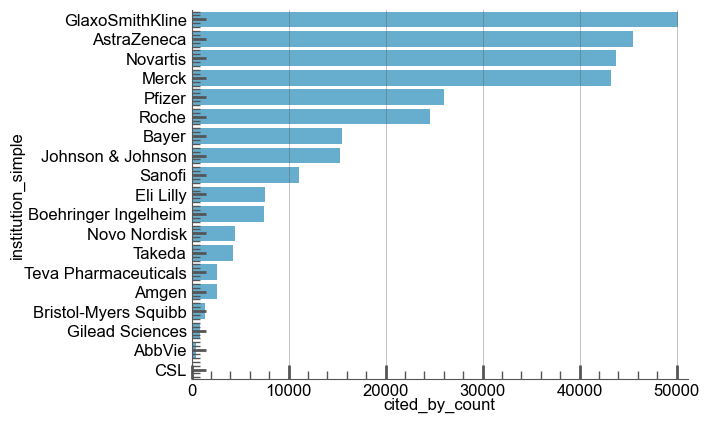

In [51]:
with aq.load_theme("scientific"):
    sns.barplot(data = group_bigpharma, x = "cited_by_count", y = "institution_simple", orient = "h",  legend = True)
    #plt.xticks(rotation = 90)
    plt.show()

In [52]:
group_national_institutions = (
    group_institutions_sum
    .head(4)  # 3 top national institutions but without Harvard
    .filter(pl.col("institution_simple") != "Harvard University")
    .filter(pl.col("institution_simple") != "University College London")
    .with_columns([pl.lit("National Institution").alias("kind")])
    .drop("institution_name")
)
impact_universities = top_10_universities["cited_by_count"].sum()/top_10_universities["count"].sum()
impact_bigpharma = group_bigpharma["cited_by_count"].sum()/group_bigpharma["count"].sum()
impact_national = group_national_institutions["cited_by_count"].sum()/ group_national_institutions["count"].sum()
print(impact_national)
print(impact_universities)
print(impact_bigpharma)

61.596665055582406
63.478127136021875
70.18053016453382


In [53]:
top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)


group_bigpharma = group_bigpharma.select(top_10_universities.columns)

top_20 = pl.concat([
    top_10_universities.head(7),
    group_bigpharma.head(6),
    group_national_institutions
], how="vertical").sort("cited_by_count", descending=True)


C:\Users\noahr\AppData\Local\Temp\ipykernel_452\1976038920.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)


<Figure size 640x480 with 0 Axes>

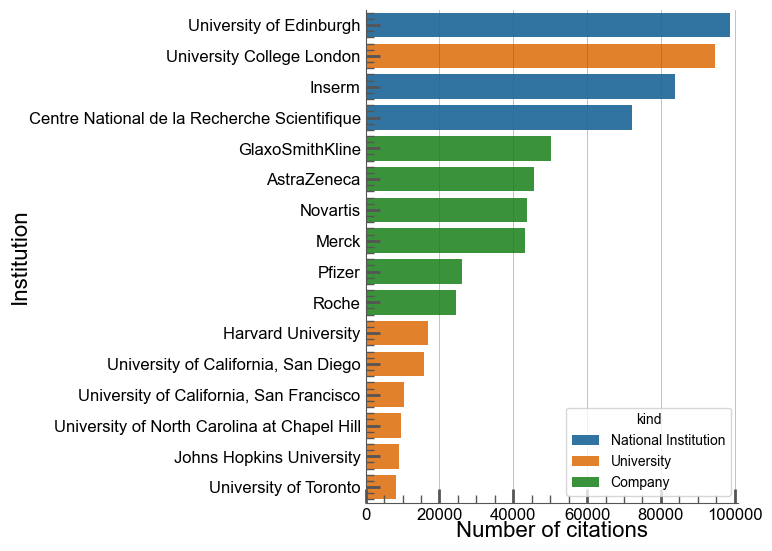

In [54]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)
    plt.xlabel("Number of citations", fontsize = 16)
    plt.ylabel("Institution", fontsize=16)
    plt.show()

In [55]:
means_yearly_citations = [works[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]

new_studies = works.filter(pl.col("year") == 2012)
means_2012_yearly_citations = [new_studies[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]

years = range(13)
years_2012 = range(2012, 2025)

list_means_yearly_citations = []
for year in years:
    new_studies = works.filter(pl.col("year") == 2012 + year)
    list_means_yearly_citations.append([new_studies[f"cited_by_count_{i}"].mean() for i in range(2012 + year, 2025)])

<Figure size 640x480 with 0 Axes>

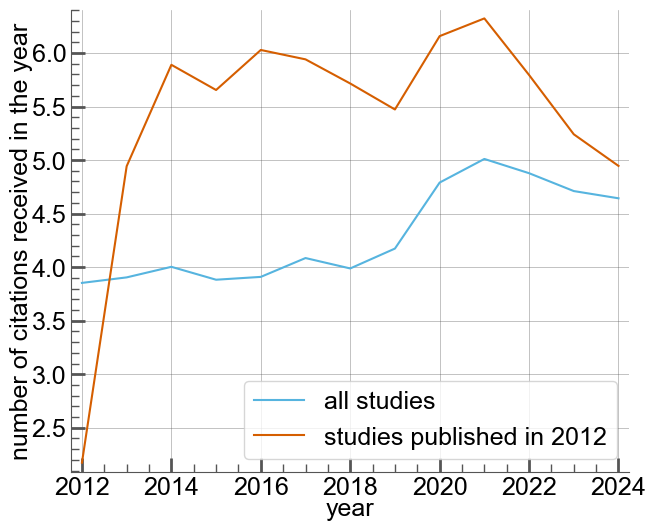

In [56]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(x = years_2012, y =  means_yearly_citations, label = "all studies")
    sns.lineplot(x = years_2012, y =  means_2012_yearly_citations, label = "studies published in 2012")
    plt.xlabel("year", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.show()

In [57]:
number_studies_per_year = (
    works
    .with_columns(pl.lit(1).alias("count"))
    .select(["year", "count"])
    .group_by("year")
    .sum()
    .sort("year")
)

number_studies_per_year_series = pd.Series(
    number_studies_per_year["count"].to_list(),
    index=number_studies_per_year["year"].to_list()
)
number_studies_per_year_series = number_studies_per_year_series.reindex(years_2012, fill_value=0)

number_studies_per_year_series = (number_studies_per_year_series - number_studies_per_year_series.min()) / \
                                 (number_studies_per_year_series.max() - number_studies_per_year_series.min())

means_yearly_citations = []
for year in years_2012:
    new_studies = works.filter(pl.col("year") == year)
    mean_cites = [new_studies[f"cited_by_count_{i}"].mean() for i in range(year, 2025)]
    means_yearly_citations.append(sum(mean_cites)/len(mean_cites)) 

means_yearly_citations_series = pd.Series(means_yearly_citations, index=years_2012)
means_yearly_citations_series = (means_yearly_citations_series - means_yearly_citations_series.min()) / \
                                (means_yearly_citations_series.max() - means_yearly_citations_series.min())


<Figure size 640x480 with 0 Axes>

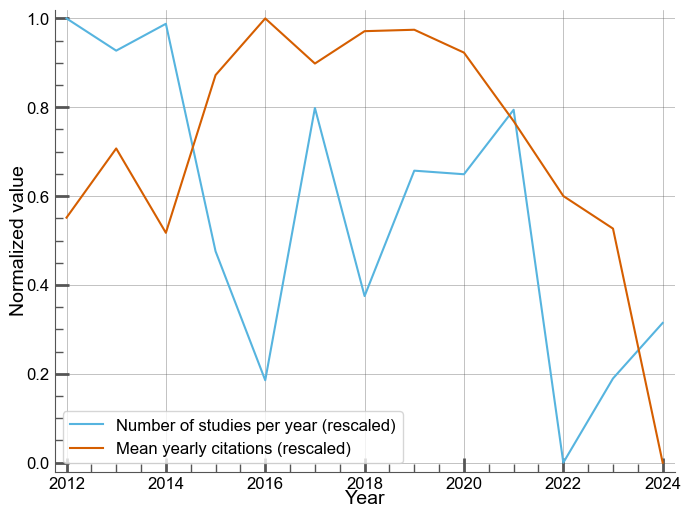

In [58]:
with aq.load_theme("scientific"):
    fig, ax = plt.subplots(figsize=(8,6))
    sns.lineplot(x=years_2012, y=number_studies_per_year_series.values, label="Number of studies per year (rescaled)", ax=ax)
    sns.lineplot(x=years_2012, y=means_yearly_citations_series.values, label="Mean yearly citations (rescaled)", ax=ax)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Normalized value", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(fontsize=12)
    plt.show()


<Figure size 640x480 with 0 Axes>

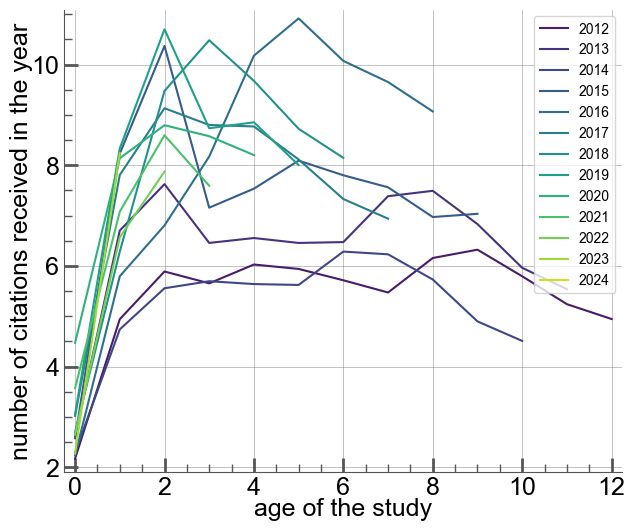

In [59]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_means_yearly_citations[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

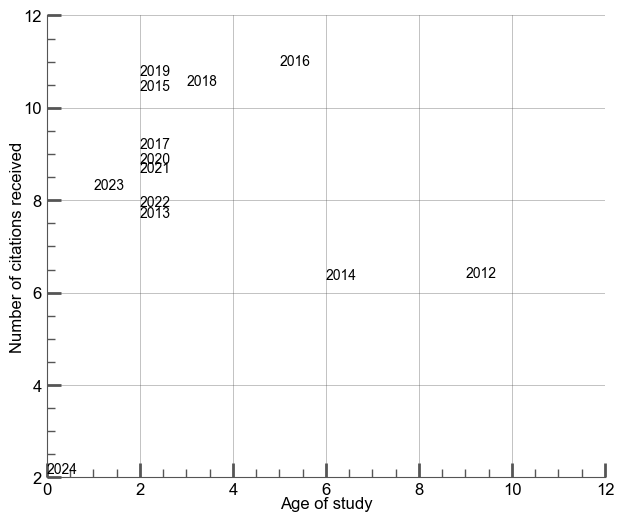

In [60]:
plt.figure(figsize=(7.2, 6))

for i in range(13):
    liste = pd.Series(list_means_yearly_citations[i])
    x = liste.argmax()
    y = liste.max()
    plt.text(x=x, y=y, s=f"{2012 + i}", fontweight=50)
plt.xlabel("Age of study", fontsize=12)  # explains x
plt.ylabel("Number of citations received", fontsize=12)   
plt.xlim(0,12)
plt.ylim(2,12)
plt.show()


In [61]:
new_studies = works.filter(pl.col("year") == 2012)


top_studies = new_studies.sort("cited_by_count", descending=True).with_row_index()
superstars = top_studies.filter(pl.col("index")<=85)
stars = top_studies.filter((pl.col("index")>85) & (pl.col("index")<=852))
usual = top_studies.filter(pl.col("index")>852)

superstars_2012_yearly_citations = pd.Series([superstars[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
stars_2012_yearly_citations = pd.Series([stars[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
usual_2012_yearly_citations = pd.Series([usual[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])

superstars_2012_yearly_citations = (superstars_2012_yearly_citations - superstars_2012_yearly_citations.min())/(superstars_2012_yearly_citations.max() - superstars_2012_yearly_citations.min())
stars_2012_yearly_citations = (stars_2012_yearly_citations - stars_2012_yearly_citations.min())/(stars_2012_yearly_citations.max() - stars_2012_yearly_citations.min())
usual_2012_yearly_citations = (usual_2012_yearly_citations - usual_2012_yearly_citations.min()) / (usual_2012_yearly_citations.max() - usual_2012_yearly_citations.min())

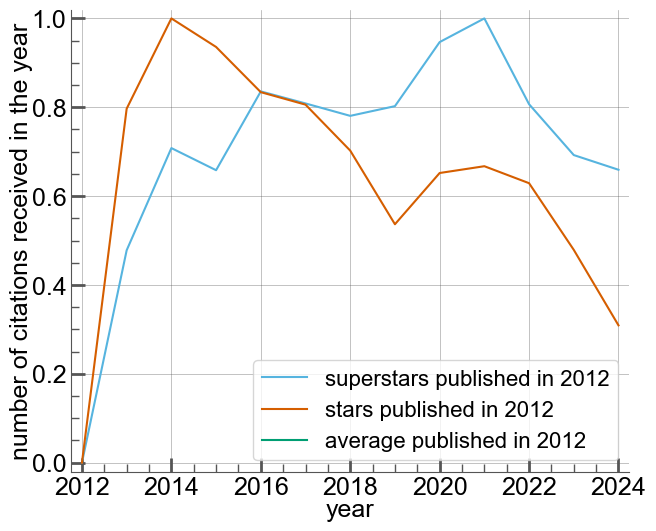

In [62]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(x = years_2012, y =  superstars_2012_yearly_citations, label = "superstars published in 2012")
    sns.lineplot(x = years_2012, y =  stars_2012_yearly_citations, label = "stars published in 2012")
    sns.lineplot(x = years_2012, y =  usual_2012_yearly_citations, label = "average published in 2012")
    plt.xlabel("year", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=16)
    plt.show()

In [63]:
mean_citations = (
    works
    .filter(pl.col("year").is_between(2012, 2024))
    .group_by("year", maintain_order=True)
    .agg(pl.mean("cited_by_count"))
    .sort("year")
)
list_mean_citations = mean_citations.select("cited_by_count").to_series()
list_citation_attention = [ (list_mean_citations[i] - np.cumsum(list_means_yearly_citations[i]))/np.sum(list_means_yearly_citations[i]) for i in range(13)]
list_citation_attention

[array([ 0.72243951,  0.65211207,  0.56830902,  0.48785281,  0.40207821,
         0.31754975,  0.23622824,  0.15835876,  0.07074368, -0.01922519,
        -0.10167658, -0.17624836, -0.24661914]),
 array([ 0.73799408,  0.64990856,  0.54971293,  0.46485369,  0.37871898,
         0.29386771,  0.20879197,  0.11173748,  0.01328091, -0.07649234,
        -0.15485519, -0.2276449 ]),
 array([ 0.77377591,  0.69092127,  0.5937813 ,  0.49420051,  0.3956086 ,
         0.29732004,  0.18745066,  0.07852973, -0.02164556, -0.10727583,
        -0.18613305]),
 array([ 0.75592514,  0.6436782 ,  0.50227666,  0.40467377,  0.30192574,
         0.19158565,  0.08520769, -0.01790747, -0.11297431, -0.2089093 ]),
 array([ 0.7677093 ,  0.6881961 ,  0.59484955,  0.48273397,  0.34313587,
         0.19338429,  0.05520578, -0.07720733, -0.20160554]),
 array([ 0.79687052,  0.66656522,  0.51414687,  0.36727387,  0.22089914,
         0.08546161, -0.03686349, -0.15268392]),
 array([ 0.7806814 ,  0.66743382,  0.49665398,  0

<Figure size 640x480 with 0 Axes>

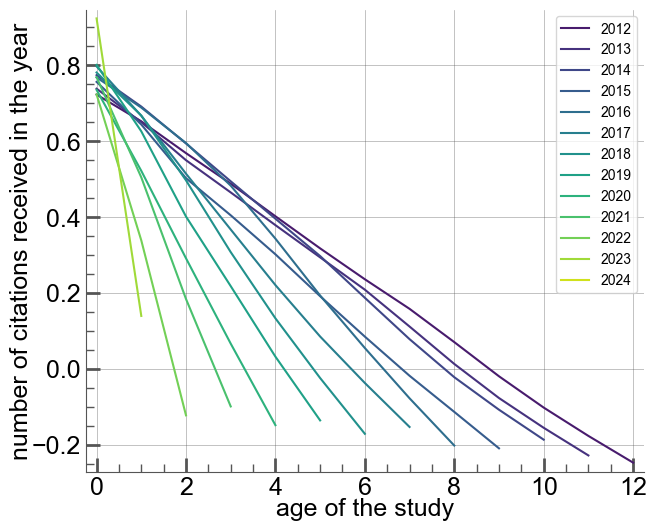

In [64]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_citation_attention[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [65]:
works = works.with_columns(
    primary_topic = pl.col("primary_topic").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_subfield = pl.col("primary_subfield").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_field = pl.col("primary_field").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True), 
    primary_domain = pl.col("primary_domain").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True)
)
works

shape: (26_115, 397)
┌────────────┬─────────────┬──────┬────────────┬───┬────────┬────────────┬────────────┬────────────┐
│ index_work ┆ title       ┆ year ┆ cited_by_c ┆ … ┆ review ┆ meta_analy ┆ mean_past_ ┆ mean_past_ │
│ ---        ┆ ---         ┆ ---  ┆ ount       ┆   ┆ ---    ┆ sis        ┆ contributi ┆ mncs_insti │
│ u32        ┆ str         ┆ i64  ┆ ---        ┆   ┆ bool   ┆ ---        ┆ ons_instit ┆ tutions    │
│            ┆             ┆      ┆ i64        ┆   ┆        ┆ bool       ┆ …          ┆ ---        │
│            ┆             ┆      ┆            ┆   ┆        ┆            ┆ ---        ┆ f64        │
│            ┆             ┆      ┆            ┆   ┆        ┆            ┆ f64        ┆            │
╞════════════╪═════════════╪══════╪════════════╪═══╪════════╪════════════╪════════════╪════════════╡
│ 0          ┆ the chemo-t ┆ 1948 ┆ 7          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ herapeutie  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ aetion o…   ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 1          ┆ the constit ┆ 1948 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ ution of    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ pbotostilb… ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 2          ┆ antryeide a ┆ 1950 ┆ 19         ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ aew trypano ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ cidal d…    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 3          ┆ stimulus‐se ┆ 1968 ┆ 1402       ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ cretion     ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ coupling:   ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ t…          ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 4          ┆ the         ┆ 1968 ┆ 564        ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ biological  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ properties  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ of t…       ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ …          ┆ …           ┆ …    ┆ …          ┆ … ┆ …      ┆ …          ┆ …          ┆ …          │
│ 26110      ┆ issue       ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ information ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 26111      ┆             ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│ 26112      ┆ inhibition  ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 85.857143  ┆ 1.105603   │
│            ┆ of the      ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ upregulated ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ …           ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 26113      ┆ expression  ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 0.0        ┆ 1.0        │
│            ┆ of concern: ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ dose‐de…    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│ 26114      ┆ agonists of ┆ 2024 ┆ 0          ┆ … ┆ false  ┆ false      ┆ 21.882353  ┆ 0.959609   │
│            ┆ the opioid  ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
│            ┆ δ‐recep…    ┆      ┆            ┆   ┆        ┆            ┆            ┆            │
└────────────┴─────────────┴──────┴─────

In [66]:
group_topics = (
    works
    .group_by("primary_topic")
    .agg([
        pl.count().alias("count"),  # nombre de publications
        pl.sum("cited_by_count").alias("cited_by_count")  # total des citations
    ])
    .sort("cited_by_count", descending=True)
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_452\2584677564.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),  # nombre de publications


<Figure size 640x480 with 0 Axes>

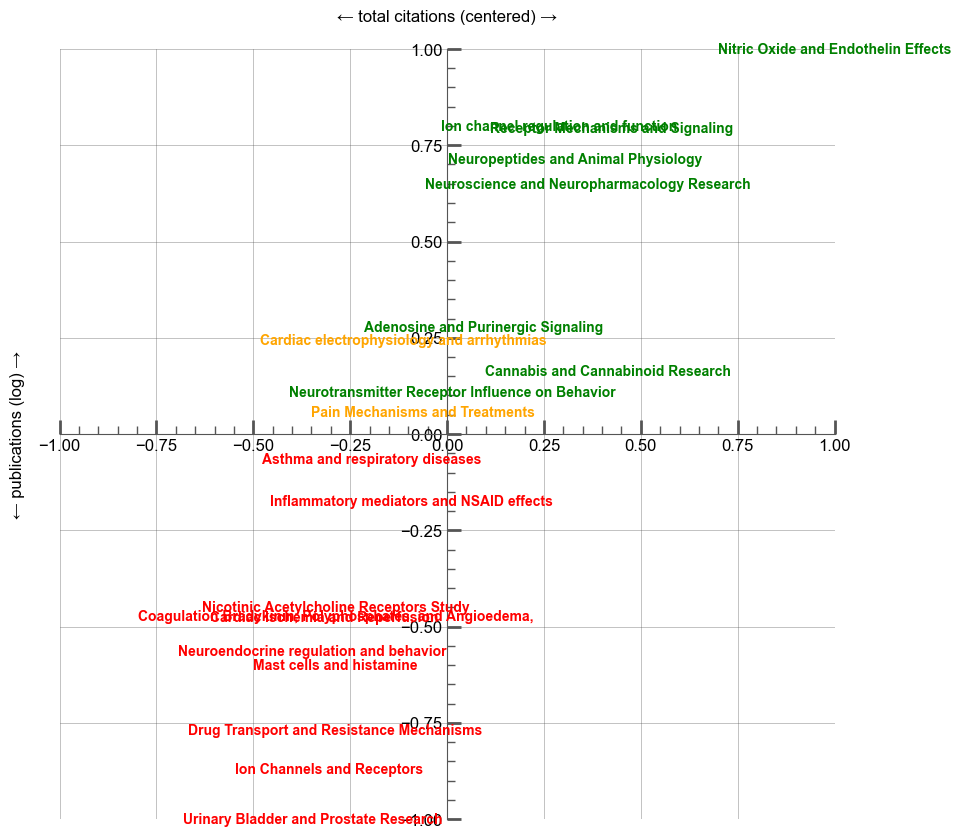

In [67]:
# --- 2️⃣ Garder le top 10 ---
top_10_topics = group_topics.head(20)

# --- 3️⃣ Préparer les coordonnées pour le plot ---
top_10_topics = top_10_topics.with_columns([
    pl.col("count").log().alias("publications_log")  # log du nombre de publications
])

mean_cit = top_10_topics["cited_by_count"].mean()
top_10_topics = top_10_topics.with_columns(
    (pl.col("cited_by_count") - mean_cit).alias("citations_centered")
)

# extraire les colonnes en tant que Series, puis en numpy
pub_log = top_10_topics["publications_log"].to_numpy()
y_min = np.min(pub_log)
y_max = np.max(pub_log)

citations = top_10_topics["cited_by_count"].to_numpy()
cit_mean = np.mean(citations)
cit_max_abs = np.max(np.abs(citations - cit_mean))

top_10_topics = top_10_topics.with_columns([
    ((pl.col("publications_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
    ((pl.col("cited_by_count") - cit_mean) / cit_max_abs).alias("x_viz")
])

# --- 4️⃣ Plot ---
plt.figure(figsize=(10, 10))
for name, x, y in zip(
    top_10_topics["primary_topic"],
    top_10_topics["x_viz"],
    top_10_topics["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)


plt.xlabel("← total citations (centered) →", labelpad=-320)
plt.ylabel("← publications (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

plt.show()

C:\Users\noahr\AppData\Local\Temp\ipykernel_452\1503608326.py:15: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  topics_pivot = covid.pivot(


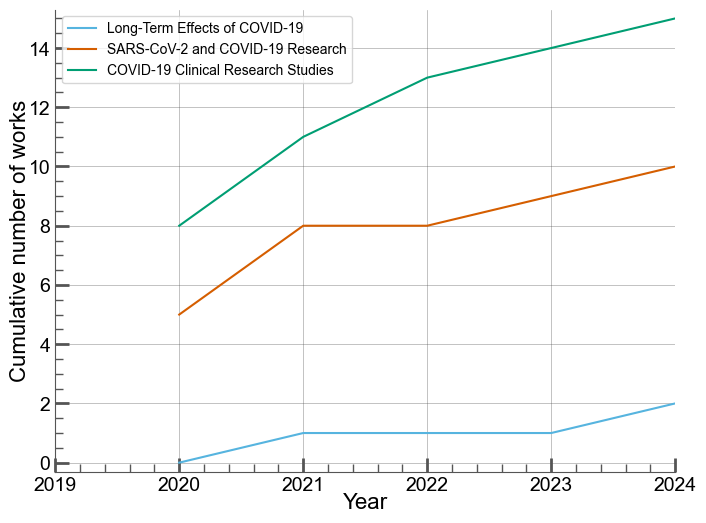

In [68]:
covid = (
    works
    .select(["primary_topic", "year", "title"])
    .filter(
        pl.col("primary_topic").is_in([
            "COVID-19 Clinical Research Studies",
            "SARS-CoV-2 and COVID-19 Research",
            "Long-Term Effects of COVID-19"
        ])
    )
    .group_by(["primary_topic", "year"])
    .agg(pl.count("title").alias("count"))
)

topics_pivot = covid.pivot(
    values="count",
    index="year",
    columns="primary_topic"
).sort("year")

topics_pivot = topics_pivot.fill_null(0)

for col in topics_pivot.columns[1:]:  
    topics_pivot = topics_pivot.with_columns(
        pl.col(col).cum_sum().alias(col)
    )

years = topics_pivot["year"].to_list()
with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    for col in topics_pivot.columns[1:]:
        plt.plot(years, topics_pivot[col].to_list(), label=col)
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Cumulative number of works", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(2019, 2024)
    plt.legend()
    plt.show()


<Figure size 640x480 with 0 Axes>

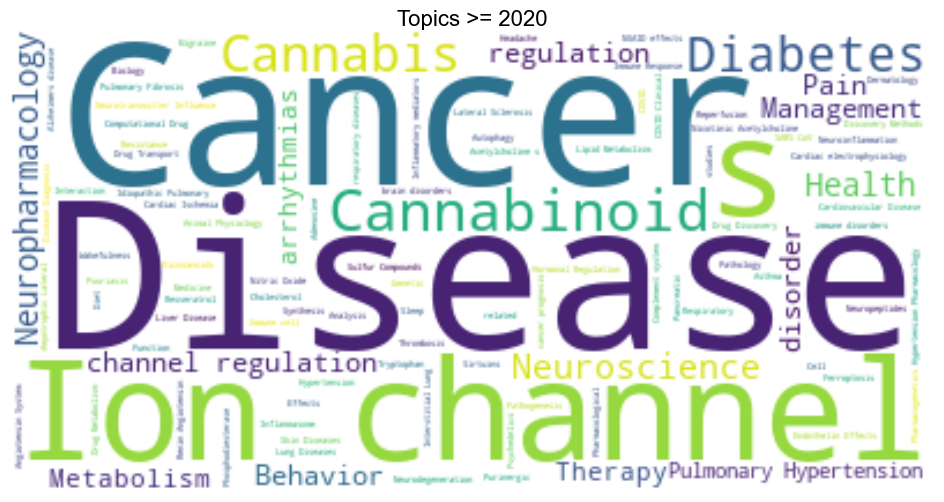

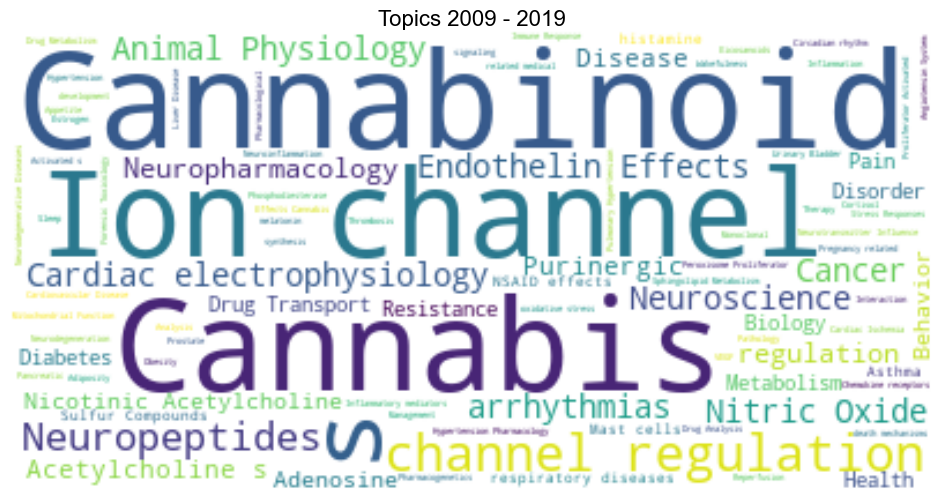

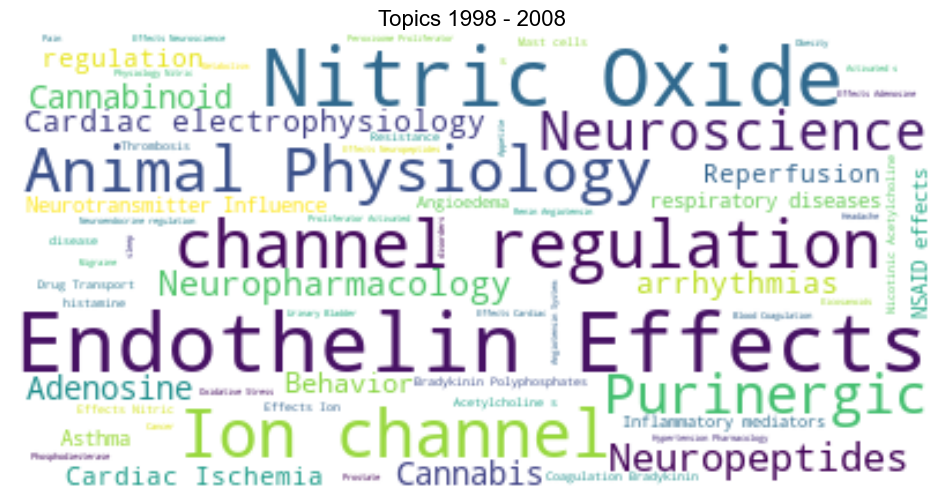

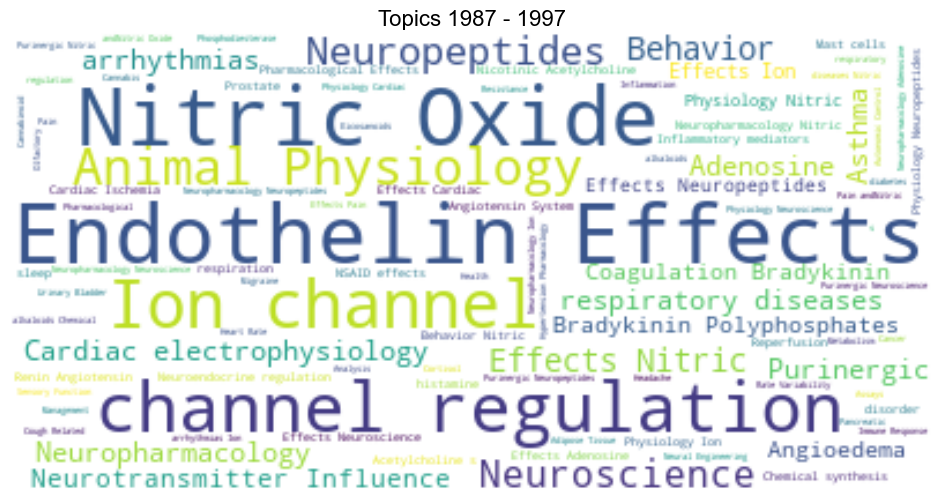

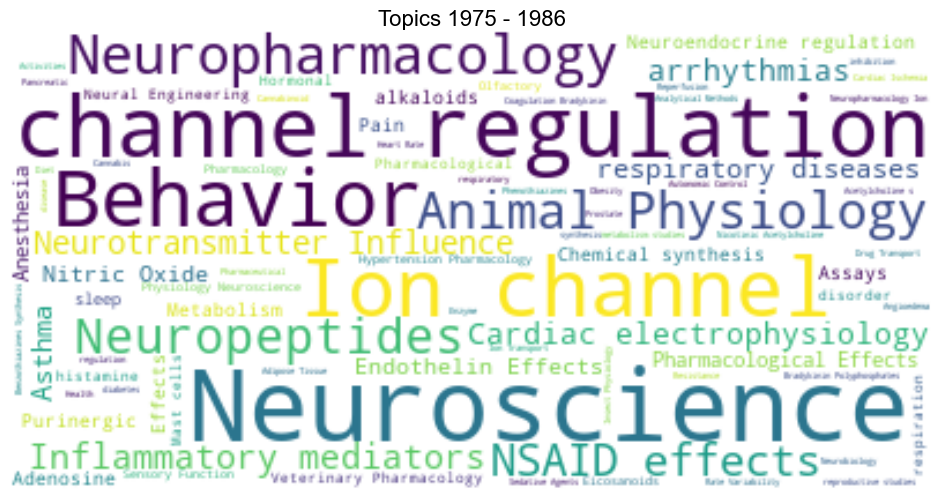

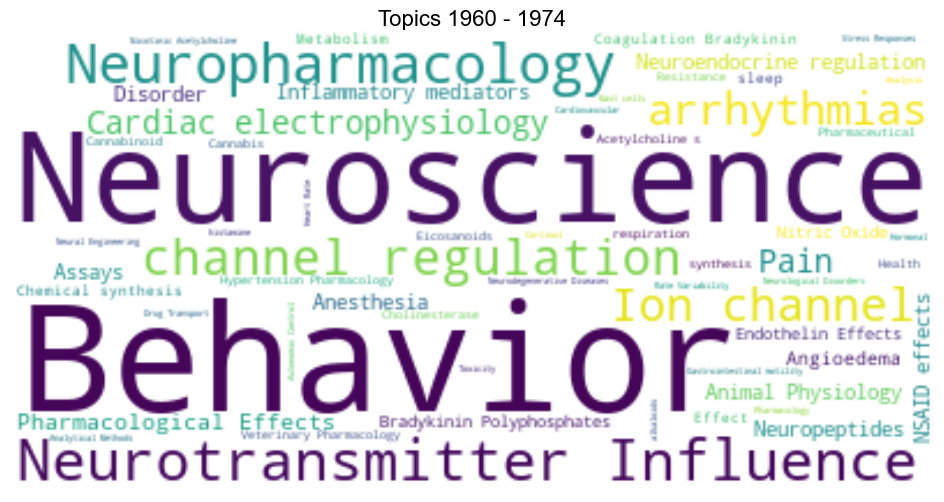

In [69]:
import wordcloud as wc

year_ranges = [
    (">= 2020", pl.col("year") >= 2020),
    ("2009 - 2019", (pl.col("year") >= 2009) & (pl.col("year") < 2020)),
    ("1998 - 2008", (pl.col("year") >= 1998) & (pl.col("year") < 2009)),
    ("1987 - 1997", (pl.col("year") >= 1987) & (pl.col("year") < 1998)),
    ("1975 - 1986", (pl.col("year") >= 1975) & (pl.col("year") < 1987)),
    ("1960 - 1974", (pl.col("year") >= 1960) & (pl.col("year") < 1975)),
]

stopwords_custom = ["Research", "Treatment", "Signaling", "Applications", 
                    "Mechanisms", "research", " s ", "Receptor", 
                    "function", "Studies","treatment","based","Study"]

for label, condition in year_ranges:
    works_new = works.filter(condition)

    primary_topics = (
        works_new
        .filter(pl.col("primary_topic").is_not_null())
        .select("primary_topic")
        .to_series()
        .to_list()
    )

    text = " ".join(primary_topics)
    for word in stopwords_custom:
        text = text.replace(word, "")


    wordcloud = wc.WordCloud(background_color="white").generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topics {label}", fontsize=16)
    plt.axis("off")
    plt.show()


In [72]:
import os
output_dir = "../../data/vosviewer"


for label, condition in year_ranges:
    works_period = works.filter(condition).filter(pl.col("primary_topic").is_not_null())

    # Extraire les topics et nettoyer les stopwords
    primary_topics = works_period.select("primary_topic").to_series().to_list()
    cleaned_topics = []
    for topic in primary_topics:
        topic_clean = str(topic)
        for word in stopwords_custom:
            topic_clean = topic_clean.replace(word, "")
        topic_clean = topic_clean.strip()  # enlever espaces en trop
        if topic_clean:  # ignorer les lignes vides
            cleaned_topics.append(topic_clean)

    if not cleaned_topics:
        print(f"Aucune donnée après nettoyage pour {label}, fichier ignoré.")
        continue

    # Préparer le DataFrame Polars avec la colonne 'Title'
    df_cleaned = pl.DataFrame({"Title": cleaned_topics})

    # Nom de fichier sûr
    safe_label = label.replace(" ", "").replace(">=", "_sup")
    output_path = os.path.join(output_dir, f"topics_bjp_{safe_label}.csv")

    df_cleaned.write_csv(output_path)

    print(f"✅ File created : {output_path} ({len(cleaned_topics)} lines)")


✅ File created : ../../data/vosviewer\topics_bjp__sup2020.csv (1572 lines)
✅ File created : ../../data/vosviewer\topics_bjp_2009-2019.csv (4973 lines)
✅ File created : ../../data/vosviewer\topics_bjp_1998-2008.csv (6334 lines)
✅ File created : ../../data/vosviewer\topics_bjp_1987-1997.csv (6643 lines)
✅ File created : ../../data/vosviewer\topics_bjp_1975-1986.csv (3397 lines)
✅ File created : ../../data/vosviewer\topics_bjp_1960-1974.csv (1592 lines)


In [73]:
import bar_chart_race as bcr


topics_pivot = (
    works
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([
        pl.count("title").alias("n")  
    ])
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)

topics_pivot_pd = topics_pivot.to_pandas().set_index("year")

topics_pivot_pd = topics_pivot_pd.cumsum()


topics_pivot_pd.index = pd.PeriodIndex(topics_pivot_pd.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd,
    filename='bjp_topics_over_time.mp4',  
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the Top Topics Over Time',
    bar_size=.95,
    interpolate_period=True
)


C:\Users\noahr\AppData\Local\Temp\ipykernel_452\3606135401.py:11: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(index="year", columns="primary_topic", values="n")
Locator attempting to generate 4321 ticks ([-17.0, ..., 847.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4321 ticks ([-17.0, ..., 847.0]), which exceeds Locator.MAXTICKS (1000).
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial.
  f

KeyboardInterrupt: 

In [ ]:
smoothing = 5
start_year = 1920

topics_pivot = (
    works
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([pl.count("title").alias("n")])  
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)


topics_pivot_pd = topics_pivot.to_pandas().set_index("year")
topics_pivot_pd_smooth = topics_pivot_pd.copy()

for index in topics_pivot_pd.index:
    debut = max(start_year, index - smoothing)
    years_range = [y for y in range(debut, index+1) if y in topics_pivot_pd.index]
    topics_pivot_pd_smooth.loc[index, :] = topics_pivot_pd.loc[years_range, :].sum()

topics_pivot_pd_smooth.index = pd.PeriodIndex(topics_pivot_pd_smooth.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd_smooth,
    filename='bjp_topics_over_time_5ysmooth.mp4',
    writer='ffmpeg',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the top topics along the years (5-year period)',
    bar_size=.95,
    interpolate_period=True
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_14744\1171743093.py:9: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(index="year", columns="primary_topic", values="n")
Locator attempting to generate 4321 ticks ([-17.0, ..., 847.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4321 ticks ([-17.0, ..., 847.0]), which exceeds Locator.MAXTICKS (1000).
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial.
  

In [ ]:

selected_topics = [
    "Nitric oxide and Endothelin Effects",
    "Ion channel regulation and function",
    "Receptor Mechanisms and Signaling",
    "Neuropeptides and Animal Physiology"
]

works_filtered = works.filter(
    (pl.col("primary_topic").is_in(selected_topics)) &
    (pl.col("primary_topic").is_not_null()) &
    (pl.col("year") >= start_year)
)
topics_pivot = (
    works_filtered
    .group_by(["primary_topic", "year"])
    .agg(pl.count("title").alias("count"))
    .pivot(index="year", columns="primary_topic", values="count")
    .fill_null(0)
    .sort("year")
)

topics_pivot = topics_pivot.with_columns([
    pl.col(col).cum_sum().alias(col) for col in selected_topics if col in topics_pivot.columns
])

topics_pivot


C:\Users\noahr\AppData\Local\Temp\ipykernel_7972\2836160933.py:17: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(index="year", columns="primary_topic", values="count")


shape: (57, 4)
┌──────┬──────────────────────────┬─────────────────────────┬─────────────────────────────────┐
│ year ┆ Neuropeptides and Animal ┆ Receptor Mechanisms and ┆ Ion channel regulation and fun… │
│ ---  ┆ Physi…                   ┆ Signal…                 ┆ ---                             │
│ i64  ┆ ---                      ┆ ---                     ┆ u32                             │
│      ┆ u32                      ┆ u32                     ┆                                 │
╞══════╪══════════════════════════╪═════════════════════════╪═════════════════════════════════╡
│ 1968 ┆ 2                        ┆ 4                       ┆ 1                               │
│ 1969 ┆ 7                        ┆ 10                      ┆ 4                               │
│ 1970 ┆ 13                       ┆ 20                      ┆ 17                              │
│ 1971 ┆ 18                       ┆ 26                      ┆ 30                              │
│ 1972 ┆ 24                       ┆ 41                      ┆ 41                              │
│ …    ┆ …                        ┆ …                       ┆ …                               │
│ 2020 ┆ 1343                     ┆ 1434                    ┆ 1490                            │
│ 2021 ┆ 1352                     ┆ 1449                    ┆ 1499                            │
│ 2022 ┆ 1354                     ┆ 1463                    ┆ 1504                            │
│ 2023 ┆ 1357                     ┆ 1484                    ┆ 1506                            │
│ 2024 ┆ 1359                     ┆ 1501                    ┆ 1511                            │
└──────┴──────────────────────────┴─────────────────────────┴─────────────────────────────────┘

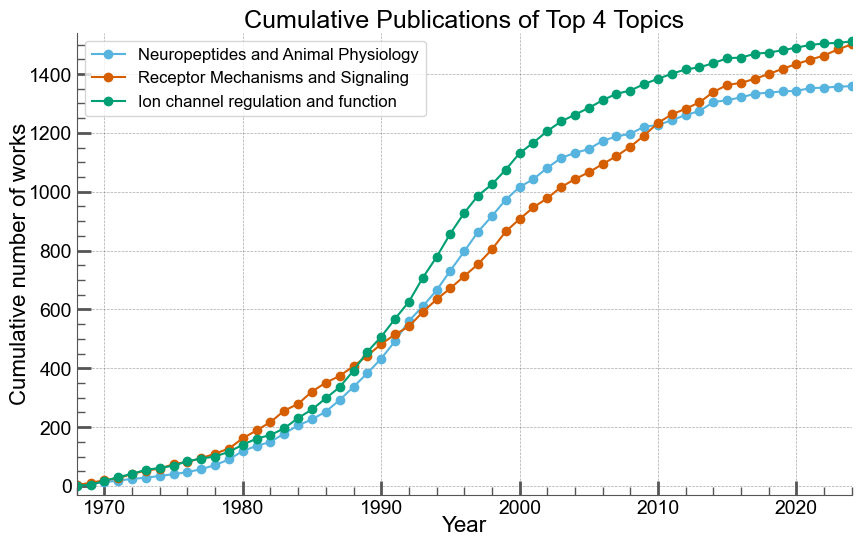

In [ ]:
years = topics_pivot["year"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))
    
    for col in topics_pivot.columns:
        if col != "year":  
            plt.plot(years, topics_pivot[col].to_list(), label=col, marker='o')
    
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Cumulative number of works", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(min(years), max(years)) 
    plt.legend(fontsize=12)
    plt.title("Cumulative Publications of Top 4 Topics", fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [ ]:
group_subfields_bis = (
    works
    .drop_nulls(subset=["primary_subfield"])
    .select(["primary_subfield", "year", "title"])
    .group_by(["primary_subfield", "year"])
    .agg(pl.count("title").alias("count"))
)

subfields_pivot = (
    group_subfields_bis
    .pivot(
        values="count",
        index="year",
        columns="primary_subfield"
    )
    .sort("year")
    .fill_null(0)
)

subfields_pivot = subfields_pivot.select(
    ["year"] + [
        pl.col(col).cum_sum().alias(col) 
        for col in subfields_pivot.columns if col != "year"
    ]
)

subfields_pivot_pd = subfields_pivot.to_pandas()
subfields_pivot_pd.index = pd.to_datetime(subfields_pivot_pd["year"], format="%Y")
subfields_pivot_pd = subfields_pivot_pd.drop(columns="year")

bcr.bar_chart_race(
    df=subfields_pivot_pd,
    filename='bjp_subfields_over_time.mp4', 
    orientation='h',
    sort='desc',
    n_bars=5,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    period_length=1000,
    period_fmt='%Y',
    title='Evolution of the top subfields along the years',
    bar_size=.95,
    interpolate_period=True
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_7972\1093276102.py:11: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 130 (\x82) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Ro

In [ ]:
top_100_authors = top_authors.head(100)

names = []
institutions = []
countries = []

for aid in top_100_authors["by"].to_list():
    if not isinstance(aid, str):
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    author = alex.Authors()[aid]
    names.append(author.get("display_name"))

    inst_list = author.get("affiliations") or []
    if len(inst_list) > 0:
        inst_id = inst_list[0]["institution"].get("id")
        if isinstance(inst_id, str):
            institutions.append(inst_id)
            try:
                countries.append(alex.Institutions()[inst_id].get("country_code"))
            except Exception:
                countries.append(None)
        else:
            institutions.append(None)
            countries.append(None)
    else:
        institutions.append(None)
        countries.append(None)

top_100_authors = top_100_authors.with_columns([
    pl.Series("name", names),
    pl.Series("institution", institutions),
    pl.Series("country", countries)
])

top_100_authors

shape: (100, 10)
┌──────────────┬───────┬────────┬──────────────┬───┬───────┬──────────────┬──────────────┬─────────┐
│ by           ┆ title ┆ year   ┆ cited_by_cou ┆ … ┆ count ┆ name         ┆ institution  ┆ country │
│ ---          ┆ ---   ┆ ---    ┆ nt           ┆   ┆ ---   ┆ ---          ┆ ---          ┆ ---     │
│ str          ┆ str   ┆ i64    ┆ ---          ┆   ┆ i64   ┆ str          ┆ str          ┆ str     │
│              ┆       ┆        ┆ i64          ┆   ┆       ┆              ┆              ┆         │
╞══════════════╪═══════╪════════╪══════════════╪═══╪═══════╪══════════════╪══════════════╪═════════╡
│ https://open ┆ null  ┆ 482324 ┆ 21840        ┆ … ┆ 240   ┆ S P H        ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Alexander    ┆ alex.org/I14 ┆         │
│ 904197…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 226353…      ┆         │
│ https://open ┆ null  ┆ 141409 ┆ 14765        ┆ … ┆ 71    ┆ Salvador     ┆ https://open ┆ ES      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Moncada      ┆ alex.org/I63 ┆         │
│ 053578…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 634437       ┆         │
│ https://open ┆ null  ┆ 154809 ┆ 12234        ┆ … ┆ 77    ┆ John A.      ┆ https://open ┆ FR      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Peters       ┆ alex.org/I12 ┆         │
│ 683097…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 946715…      ┆         │
│ https://open ┆ null  ┆ 98876  ┆ 12065        ┆ … ┆ 49    ┆ Elena        ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Faccenda     ┆ alex.org/I98 ┆         │
│ 289549…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 677209       ┆         │
│ https://open ┆ null  ┆ 134920 ┆ 11872        ┆ … ┆ 67    ┆ Eamonn Kelly ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆              ┆ alex.org/I36 ┆         │
│ 537650…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 234482       ┆         │
│ …            ┆ …     ┆ …      ┆ …            ┆ … ┆ …     ┆ …            ┆ …            ┆ …       │
│ https://open ┆ null  ┆ 64172  ┆ 2516         ┆ … ┆ 32    ┆ Martin C.    ┆ https://open ┆ DE      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Michel       ┆ alex.org/I42 ┆         │
│ 408693…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 100940…      ┆         │
│ https://open ┆ null  ┆ 2010   ┆ 2474         ┆ … ┆ 1     ┆ K.L.         ┆ https://open ┆ GB      │
│ alex.org/A51 ┆       ┆        ┆              ┆   ┆       ┆ Philpott     ┆ alex.org/I18 ┆         │
│ 099819…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 895097…      ┆         │
│ https://open ┆ null  ┆ 2010   ┆ 2474         ┆ … ┆ 1     ┆ J. P. HUGHES ┆ https://open ┆ US      │
│ alex.org/A51 ┆       ┆        ┆              ┆   ┆       ┆              ┆ alex.org/I42 ┆         │
│ 099337…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 100894…      ┆         │
│ https://open ┆ null  ┆ 2010   ┆ 2474         ┆ … ┆ 1     ┆ S. Rees      ┆ https://open ┆ GB      │
│ alex.org/A51 ┆       ┆        ┆              ┆   ┆       ┆              ┆ alex.org/I18 ┆         │
│ 141727…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 895097…      ┆         │
│ https://open ┆ null  ┆ 2010   ┆ 2474         ┆ … ┆ 1     ┆ S. Barret    ┆ https://open ┆ GB      │
│ alex.org/A50 ┆       ┆        ┆              ┆   ┆       ┆ Kalindjian   ┆ alex.org/I18 ┆         │
│ 660771…      ┆       ┆        ┆              ┆   ┆       ┆              ┆ 393575…      ┆         │
└──────────────┴───────┴────────┴──────────────┴───┴───────┴──────────────┴──────────────┴─────────┘

In [ ]:
first_names = []

for n in top_100_authors["name"]:
    if isinstance(n, str):
        first_author = n.split("&")[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    elif isinstance(n, list) and len(n) > 0:
        first_author = n[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    else:
        first_names.append(None)


C:\Users\noahr\AppData\Local\Temp\ipykernel_7972\2829698177.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","lightgray","pink"])


<Figure size 640x480 with 0 Axes>

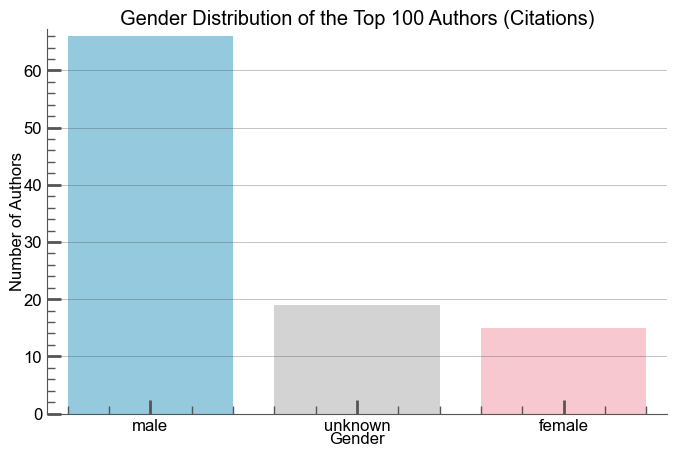

In [ ]:
import gender_guesser.detector as gender

d = gender.Detector()


def normalize_gender(g):
    if g in ["male","mostly_male"]:
        return "male"
    elif g in ["female","mostly_female"]:
        return "female"
    else:
        return "unknown"


gender_map_list = [(name, normalize_gender(d.get_gender(name))) for name in first_names]


df_gender = pd.DataFrame(gender_map_list, columns=["first_name", "gender"])

gender_counts = df_gender["gender"].value_counts()


plt.figure(figsize=(8,5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","lightgray","pink"])
plt.title("Gender Distribution of the Top 100 Authors (Citations)")
plt.xlabel("Gender")
plt.ylabel("Number of Authors")
plt.show()

In [ ]:
active_100_authors = active_authors.head(100)

names = []
institutions = []
countries = []

for aid in active_100_authors["by"].to_list():
    if not isinstance(aid, str):
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    try:
        author = alex.Authors()[aid]
    except Exception as e:

        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    names.append(author.get("display_name"))

    inst_list = author.get("affiliations") or []
    if len(inst_list) > 0:
        inst_id = inst_list[0]["institution"].get("id")
        if isinstance(inst_id, str):
            institutions.append(inst_id)
            try:
                countries.append(alex.Institutions()[inst_id].get("country_code"))
            except Exception:
                countries.append(None)
        else:
            institutions.append(None)
            countries.append(None)
    else:
        institutions.append(None)
        countries.append(None)

active_100_authors = active_100_authors.with_columns([
    pl.Series("name", names),
    pl.Series("institution", institutions),
    pl.Series("country", countries)
])


active_100_authors

KeyboardInterrupt: 

In [ ]:
first_names = []

for n in active_100_authors["name"]:
    if isinstance(n, str):
        first_author = n.split("&")[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    elif isinstance(n, list) and len(n) > 0:
        first_author = n[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    else:
        first_names.append(None)



C:\Users\noahr\AppData\Local\Temp\ipykernel_2164\2268833146.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","lightgray","pink"])


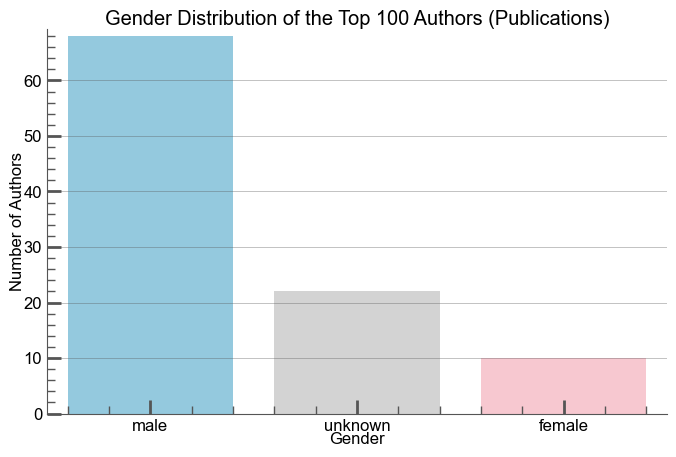

In [ ]:
d = gender.Detector()

def normalize_gender(g):
    if g in ["male","mostly_male"]:
        return "male"
    elif g in ["female","mostly_female"]:
        return "female"
    else:
        return "unknown"

gender_map_list = [(name, normalize_gender(d.get_gender(name))) for name in first_names]

df_gender = pd.DataFrame(gender_map_list, columns=["first_name", "gender"])

gender_counts = df_gender["gender"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","lightgray","pink"])
plt.title("Gender Distribution of the Top 100 Authors (Publications)")
plt.xlabel("Gender")
plt.ylabel("Number of Authors")
plt.show()